# ICR V2.2: Real-World Data Integration and Fine-Tuning

## Project Overview

**ICR V2.2** extends the ICR V2 model by fine-tuning on real-world handwriting datasets. This notebook assumes that Phase 1 (EDA on synthetic data) and Phase 2 (CNN training on trdg data) have been completed in a separate project, producing the pretrained model `icr_v2_best.pth`.

### Objective

Fine-tune the pretrained ICR V2 model using a combination of:

1. **A-Z Handwritten Alphabets (Kaggle CSV):** A large-scale dataset of handwritten alphabets in CSV format (784 pixels per sample, representing 28x28 grayscale images).

2. **EMNIST Letters:** The Extended MNIST dataset filtered for letters (A-Z), which requires orientation correction due to transpose/rotation issues.

### Prerequisites

- Pretrained model: `icr_v2_best.pth` (from Phase 1 and Phase 2)
- Normalization parameters from Phase 2: Mean=0.7465, Std=0.2650

### Technical Considerations

- **Normalization Consistency:** Both datasets must use the EXACT normalization parameters from Phase 2 (Mean=0.7465, Std=0.2650) to maintain feature space compatibility.
- **Memory Optimization:** With over 1 million combined samples, lazy loading and efficient data structures are critical.
- **EMNIST Orientation:** EMNIST images are transposed and rotated 90 degrees counter-clockwise relative to standard orientation; this must be corrected.
- **Label Alignment:** Both datasets use 0-25 indexing for A-Z, but EMNIST uses 1-26 internally and requires mapping.

## 1. Environment Setup and Dependencies

## 1.1 ICR V2 Model Architecture Definition

Define the CNN architecture used in Phase 1 and Phase 2. This must match exactly the architecture used to train `icr_v2_best.pth`.

In [1]:
# =============================================================================
# ICR V2 Model Architecture
# =============================================================================
# This is the EXACT architecture used in Phase 1 and Phase 2.
# It must match the architecture that produced icr_v2_best.pth.
#
# Architecture: CNN with 3 Conv Blocks + 2 FC Layers
# - Conv Block 1: 1 -> 32 channels, BatchNorm, ReLU, MaxPool
# - Conv Block 2: 32 -> 64 channels, BatchNorm, ReLU, MaxPool
# - Conv Block 3: 64 -> 128 channels, BatchNorm, ReLU, MaxPool
# - FC1: 1152 -> 256 with BatchNorm and ReLU
# - FC2: 256 -> 26 (output classes)
# =============================================================================

import torch
import torch.nn as nn

class ICR_V2_Model(nn.Module):
    """
    Enhanced CNN architecture for Handwritten Character Recognition (A-Z).

    Architecture Improvements:
        - Batch Normalization after each convolution for faster convergence
        - Dropout before final FC layer to prevent overfitting
        - Deeper feature extraction with multiple conv blocks

    Input: (Batch, 1, 28, 28) - Grayscale images
    Output: (Batch, 26) - Logits for A-Z classes
    """

    def __init__(self, num_classes=26, dropout_rate=0.5):
        super(ICR_V2_Model, self).__init__()

        # Convolutional Block 1: 1 -> 32 channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32,
                              kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14

        # Convolutional Block 2: 32 -> 64 channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                              kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7

        # Convolutional Block 3: 64 -> 128 channels
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128,
                              kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 7x7 -> 3x3

        # Activation function
        self.relu = nn.ReLU()

        # Fully Connected Layers
        # After 3 pooling layers: 28 -> 14 -> 7 -> 3
        # Feature map size: 128 * 3 * 3 = 1152
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (Batch, 1, 28, 28)

        Returns:
            Output logits of shape (Batch, 26)
        """
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Flatten and FC layers
        x = self.flatten(x)
        x = self.dropout(x)  # Apply dropout before FC
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x


# Verify model architecture
print(f"{'='*60}")
print("ICR V2 MODEL ARCHITECTURE DEFINED")
print(f"{'='*60}")
test_model = ICR_V2_Model(num_classes=26, dropout_rate=0.5)
total_params = sum(p.numel() for p in test_model.parameters())
print(f"Total Parameters: {total_params:,}")
print(f"Model Size (approx): {total_params * 4 / 1e6:.2f} MB (float32)")
del test_model
print(f"{'='*60}")

ICR V2 MODEL ARCHITECTURE DEFINED
Total Parameters: 395,482
Model Size (approx): 1.58 MB (float32)


In [2]:
# =============================================================================
# ICR V2.2: Environment Setup and Dependencies
# =============================================================================
# This cell installs required packages for downloading the Kaggle dataset
# and ensures all dependencies are available.
# =============================================================================

import subprocess
import sys

def install_package(package_name):
    """Install a package using pip if not already installed."""
    try:
        __import__(package_name.replace('-', '_'))
        print(f"[OK] {package_name} is already installed.")
    except ImportError:
        print(f"[INSTALLING] {package_name}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package_name])
        print(f"[OK] {package_name} installed successfully.")

# Required packages
install_package('kagglehub')

# Verify core imports
import torch
import torchvision
import numpy as np
import pandas as pd
from pathlib import Path

print(f"\n{'='*60}")
print("ICR V2.2 - DEPENDENCIES VERIFIED")
print(f"{'='*60}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"{'='*60}")

[OK] kagglehub is already installed.

ICR V2.2 - DEPENDENCIES VERIFIED
PyTorch Version: 2.9.0+cu126
Torchvision Version: 0.24.0+cu126
NumPy Version: 2.0.2
Pandas Version: 2.2.2
CUDA Available: True


## 2. Dataset Download and Preparation
### 2.1 Download A-Z Handwritten Alphabets (Kaggle CSV)

In [3]:
# =============================================================================
# Download A-Z Handwritten Alphabets Dataset from Kaggle
# =============================================================================
# Dataset: https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format
#
# Format: CSV file where:
#   - First column: Label (0-25 for A-Z)
#   - Columns 1-784: Pixel values (28x28 = 784 pixels, grayscale 0-255)
#
# This dataset contains ~370,000+ handwritten alphabet samples.
# =============================================================================

import kagglehub

# Download the dataset (cached if already downloaded)
print("Downloading A-Z Handwritten Alphabets dataset from Kaggle...")
print("(This may take a few minutes on first run)")
print("-" * 60)

az_dataset_path = kagglehub.dataset_download("sachinpatel21/az-handwritten-alphabets-in-csv-format")

print(f"\n{'='*60}")
print("A-Z DATASET DOWNLOAD COMPLETE")
print(f"{'='*60}")
print(f"Dataset Path: {az_dataset_path}")

# List contents to identify the CSV file
import os
contents = os.listdir(az_dataset_path)
print(f"Contents: {contents}")

# Identify the CSV file
csv_files = [f for f in contents if f.endswith('.csv')]
if csv_files:
    AZ_CSV_PATH = Path(az_dataset_path) / csv_files[0]
    print(f"CSV File Found: {AZ_CSV_PATH}")
    print(f"File Size: {AZ_CSV_PATH.stat().st_size / 1e6:.2f} MB")
else:
    print("WARNING: No CSV file found in the downloaded dataset!")
    AZ_CSV_PATH = None

print(f"{'='*60}")

(This may take a few minutes on first run)
------------------------------------------------------------
Using Colab cache for faster access to the 'az-handwritten-alphabets-in-csv-format' dataset.

A-Z DATASET DOWNLOAD COMPLETE
Dataset Path: /kaggle/input/az-handwritten-alphabets-in-csv-format
Contents: ['A_Z Handwritten Data.csv', 'A_Z Handwritten Data']
CSV File Found: /kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv
File Size: 698.91 MB


### 2.2 Download EMNIST Letters Dataset

In [4]:
# =============================================================================
# Download EMNIST Letters Dataset via Torchvision
# =============================================================================
# EMNIST (Extended MNIST) is a set of handwritten character digits.
# The 'letters' split contains A-Z (26 classes).
#
# CRITICAL NOTES:
# 1. EMNIST uses labels 1-26 (not 0-25), so we must subtract 1.
# 2. EMNIST images are TRANSPOSED and ROTATED 90 degrees counter-clockwise
#    relative to standard orientation. We must apply:
#    - Transpose (swap rows and columns)
#    - Horizontal flip
#    to correct the orientation.
# =============================================================================

from torchvision.datasets import EMNIST

# Download EMNIST Letters (train + test splits)
print("Downloading EMNIST Letters dataset...")
print("(This may take a few minutes on first run)")
print("-" * 60)

EMNIST_ROOT = Path('./data/emnist')

# Download training set
emnist_train = EMNIST(
    root=str(EMNIST_ROOT),
    split='letters',
    train=True,
    download=True
)

# Download test set
emnist_test = EMNIST(
    root=str(EMNIST_ROOT),
    split='letters',
    train=False,
    download=True
)

print(f"\n{'='*60}")
print("EMNIST LETTERS DOWNLOAD COMPLETE")
print(f"{'='*60}")
print(f"Training Samples: {len(emnist_train):,}")
print(f"Test Samples: {len(emnist_test):,}")
print(f"Total EMNIST Samples: {len(emnist_train) + len(emnist_test):,}")
print(f"Image Shape (raw): {emnist_train[0][0].size}")
print(f"Label Range (raw): 1-26 (will be mapped to 0-25)")
print(f"{'='*60}")

(This may take a few minutes on first run)
------------------------------------------------------------


100%|██████████| 562M/562M [00:04<00:00, 124MB/s]



EMNIST LETTERS DOWNLOAD COMPLETE
Training Samples: 124,800
Test Samples: 20,800
Total EMNIST Samples: 145,600
Image Shape (raw): (28, 28)
Label Range (raw): 1-26 (will be mapped to 0-25)


## 3. Unified Data Ingestion Pipeline
### 3.1 CombinedRealWorldDataset Class Definition

This custom PyTorch Dataset class handles:
- Loading and merging A-Z CSV and EMNIST datasets
- EMNIST orientation correction (transpose + horizontal flip)
- Label normalization (EMNIST 1-26 to 0-25)
- Memory-efficient lazy loading for CSV data
- Consistent normalization using Phase 2 parameters (Mean=0.7465, Std=0.2650)

In [5]:
# =============================================================================
# CombinedRealWorldDataset: Unified Dataset for A-Z CSV + EMNIST
# =============================================================================
# This class implements memory-efficient loading of both datasets into a
# single unified stream for training. Key design decisions:
#
# 1. MEMORY OPTIMIZATION:
#    - A-Z CSV: Loaded once into memory as NumPy arrays (uint8 to save RAM)
#    - EMNIST: Accessed via torchvision's lazy loading mechanism
#    - Combined indexing allows seamless iteration over both sources
#
# 2. PREPROCESSING CONSISTENCY:
#    - All images normalized to [0, 1] then standardized with Phase 2 stats
#    - EMNIST orientation corrected via transpose + horizontal flip
#    - Output shape: (1, 28, 28) for all samples
#
# 3. LABEL ALIGNMENT:
#    - A-Z CSV: Labels already 0-25
#    - EMNIST: Labels 1-26 mapped to 0-25
# =============================================================================

import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm

class CombinedRealWorldDataset(Dataset):
    """
    Unified PyTorch Dataset combining A-Z Handwritten CSV and EMNIST Letters.

    This dataset provides a single interface to access samples from both
    data sources with consistent preprocessing and normalization.

    Attributes:
        az_data (np.ndarray): A-Z CSV pixel data, shape (N, 784), dtype uint8
        az_labels (np.ndarray): A-Z CSV labels, shape (N,), dtype int64
        emnist_data (list): List of EMNIST dataset objects (train + test)
        total_az (int): Number of A-Z CSV samples
        total_emnist (int): Number of EMNIST samples
        norm_mean (float): Normalization mean from Phase 2
        norm_std (float): Normalization std from Phase 2
    """

    def __init__(
        self,
        az_csv_path,
        emnist_datasets,
        norm_mean=0.7465,
        norm_std=0.2650,
        load_az_to_memory=True
    ):
        """
        Initialize the combined dataset.

        Args:
            az_csv_path: Path to the A-Z Handwritten CSV file
            emnist_datasets: List of EMNIST dataset objects (e.g., [train, test])
            norm_mean: Normalization mean (from Phase 2 EDA)
            norm_std: Normalization std (from Phase 2 EDA)
            load_az_to_memory: If True, load entire A-Z CSV to RAM for faster access
        """
        self.norm_mean = norm_mean
        self.norm_std = norm_std

        # ---------------------------------------------------------------------
        # Load A-Z CSV Data
        # ---------------------------------------------------------------------
        # The CSV format:
        #   - Column 0: Label (0-25 for A-Z)
        #   - Columns 1-784: Pixel values (0-255)
        #
        # We load as uint8 to minimize memory footprint (~370K samples * 784 bytes)
        # ---------------------------------------------------------------------
        print("Loading A-Z Handwritten CSV data...")

        if load_az_to_memory:
            # Read CSV with optimized dtypes
            # Using dtype specification for memory efficiency
            az_df = pd.read_csv(az_csv_path, header=None)

            # Extract labels (first column) and pixel data (remaining columns)
            self.az_labels = az_df.iloc[:, 0].values.astype(np.int64)
            self.az_data = az_df.iloc[:, 1:].values.astype(np.uint8)

            # Free the DataFrame memory
            del az_df

            self.total_az = len(self.az_labels)
            print(f"  A-Z CSV loaded: {self.total_az:,} samples")
            print(f"  Memory usage: ~{self.az_data.nbytes / 1e6:.1f} MB")
        else:
            # For extremely memory-constrained environments, use chunked reading
            # (Not recommended for training performance)
            raise NotImplementedError("Chunked loading not implemented. Use load_az_to_memory=True")

        # ---------------------------------------------------------------------
        # Store EMNIST Dataset References
        # ---------------------------------------------------------------------
        # EMNIST uses lazy loading internally, so we just store references.
        # This is memory-efficient as images are loaded on-demand.
        # ---------------------------------------------------------------------
        self.emnist_datasets = emnist_datasets if isinstance(emnist_datasets, list) else [emnist_datasets]

        # Calculate cumulative lengths for indexing
        self.emnist_lengths = [len(ds) for ds in self.emnist_datasets]
        self.total_emnist = sum(self.emnist_lengths)

        # Build cumulative index boundaries for EMNIST datasets
        self.emnist_cumulative = np.cumsum([0] + self.emnist_lengths)

        print(f"  EMNIST datasets linked: {self.total_emnist:,} samples")

        # Total dataset size
        self._total_length = self.total_az + self.total_emnist

        print(f"\n{'='*60}")
        print(f"COMBINED DATASET INITIALIZED")
        print(f"{'='*60}")
        print(f"A-Z CSV Samples: {self.total_az:,}")
        print(f"EMNIST Samples: {self.total_emnist:,}")
        print(f"TOTAL SAMPLES: {self._total_length:,}")
        print(f"Normalization: mean={self.norm_mean}, std={self.norm_std}")
        print(f"{'='*60}")

    def __len__(self):
        """Return total number of samples across both datasets."""
        return self._total_length

    def _correct_emnist_orientation(self, image):
        """
        Correct EMNIST orientation issues.

        EMNIST images are stored transposed and rotated relative to standard
        orientation. To fix this, we apply:
            1. Transpose (swap rows and columns)
            2. Horizontal flip

        This is equivalent to rotating 90 degrees clockwise then flipping.

        Args:
            image: PIL Image or numpy array

        Returns:
            Corrected PIL Image
        """
        if isinstance(image, Image.Image):
            # Transpose and flip horizontally
            return image.transpose(Image.TRANSPOSE).transpose(Image.FLIP_LEFT_RIGHT)
        else:
            # For numpy arrays
            return np.fliplr(image.T)

    def _normalize_image(self, image_tensor):
        """
        Apply Phase 2 normalization to image tensor.

        The normalization formula: (x - mean) / std

        This ensures the real-world data has the same statistical properties
        as the synthetic training data from Phase 2.

        Args:
            image_tensor: Tensor of shape (1, 28, 28) in range [0, 1]

        Returns:
            Normalized tensor
        """
        return (image_tensor - self.norm_mean) / self.norm_std

    def __getitem__(self, idx):
        """
        Retrieve a single sample by index.

        Indexing scheme:
            - idx in [0, total_az): Return A-Z CSV sample
            - idx in [total_az, total_az + total_emnist): Return EMNIST sample

        Args:
            idx: Sample index

        Returns:
            tuple: (image_tensor, label)
                - image_tensor: Shape (1, 28, 28), normalized
                - label: Integer in range [0, 25]
        """
        if idx < self.total_az:
            # -------------------------------------------------------------
            # A-Z CSV Sample
            # -------------------------------------------------------------
            # Retrieve pixel data and reshape to 28x28
            pixels = self.az_data[idx].reshape(28, 28)
            label = self.az_labels[idx]

            # Convert to float tensor [0, 1]
            image_tensor = torch.from_numpy(pixels.astype(np.float32) / 255.0)
            image_tensor = image_tensor.unsqueeze(0)  # Add channel dimension

        else:
            # -------------------------------------------------------------
            # EMNIST Sample
            # -------------------------------------------------------------
            # Adjust index for EMNIST
            emnist_idx = idx - self.total_az

            # Find which EMNIST dataset this index belongs to
            for i, (start, end) in enumerate(zip(self.emnist_cumulative[:-1],
                                                  self.emnist_cumulative[1:])):
                if start <= emnist_idx < end:
                    local_idx = emnist_idx - start
                    image, label = self.emnist_datasets[i][local_idx]
                    break

            # EMNIST labels are 1-26, convert to 0-25
            label = label - 1

            # Correct orientation (EMNIST is transposed/rotated)
            image = self._correct_emnist_orientation(image)

            # Convert to tensor [0, 1]
            image_tensor = transforms.ToTensor()(image)

        # Apply Phase 2 normalization
        image_tensor = self._normalize_image(image_tensor)

        return image_tensor, label

    def get_source(self, idx):
        """
        Identify the source dataset for a given index.

        Args:
            idx: Sample index

        Returns:
            str: 'az_csv' or 'emnist'
        """
        return 'az_csv' if idx < self.total_az else 'emnist'

    def get_class_distribution(self):
        """
        Calculate class distribution across both datasets.

        Returns:
            dict: Class counts for each label (0-25)
        """
        class_counts = {i: 0 for i in range(26)}

        # Count A-Z CSV labels
        for label in self.az_labels:
            class_counts[label] += 1

        # Count EMNIST labels (accounting for 1-26 -> 0-25 mapping)
        for ds in self.emnist_datasets:
            for _, label in tqdm(ds, desc="Counting EMNIST labels", leave=False):
                class_counts[label - 1] += 1

        return class_counts


print("CombinedRealWorldDataset class defined successfully.")

CombinedRealWorldDataset class defined successfully.


### 3.2 Instantiate Combined Dataset

In [6]:
# =============================================================================
# Instantiate the Combined Real-World Dataset
# =============================================================================
# Using normalization parameters from Phase 2:
#   - Mean: 0.7465
#   - Std: 0.2650
#
# These values were calculated from the synthetic trdg dataset and must be
# reused to ensure feature space compatibility with the pretrained model.
# =============================================================================

# Phase 2 normalization parameters (from EDA)
PHASE2_NORM_MEAN = 0.7465
PHASE2_NORM_STD = 0.2650

# Combine EMNIST train and test for maximum data
emnist_combined = [emnist_train, emnist_test]

# Create the unified dataset
combined_dataset = CombinedRealWorldDataset(
    az_csv_path=AZ_CSV_PATH,
    emnist_datasets=emnist_combined,
    norm_mean=PHASE2_NORM_MEAN,
    norm_std=PHASE2_NORM_STD,
    load_az_to_memory=True
)

# Verify single sample access
print("\nVerifying dataset access...")
sample_img, sample_label = combined_dataset[0]
print(f"Sample Image Shape: {sample_img.shape}")
print(f"Sample Image Dtype: {sample_img.dtype}")
print(f"Sample Label: {sample_label}")
print(f"Sample Source: {combined_dataset.get_source(0)}")

# Test EMNIST access
emnist_start_idx = combined_dataset.total_az
sample_img_emnist, sample_label_emnist = combined_dataset[emnist_start_idx]
print(f"\nEMNIST Sample Image Shape: {sample_img_emnist.shape}")
print(f"EMNIST Sample Label: {sample_label_emnist}")
print(f"EMNIST Sample Source: {combined_dataset.get_source(emnist_start_idx)}")

Loading A-Z Handwritten CSV data...
  A-Z CSV loaded: 372,451 samples
  Memory usage: ~292.0 MB
  EMNIST datasets linked: 145,600 samples

COMBINED DATASET INITIALIZED
A-Z CSV Samples: 372,451
EMNIST Samples: 145,600
TOTAL SAMPLES: 518,051
Normalization: mean=0.7465, std=0.265

Verifying dataset access...
Sample Image Shape: torch.Size([1, 28, 28])
Sample Image Dtype: torch.float32
Sample Label: 0
Sample Source: az_csv

EMNIST Sample Image Shape: torch.Size([1, 28, 28])
EMNIST Sample Label: 22
EMNIST Sample Source: emnist


## 4. Statistical Analysis of Combined Real-World Data
### 4.1 Dataset Size and Class Distribution Analysis

In [7]:
# =============================================================================
# Statistical Analysis of Combined Real-World Dataset
# =============================================================================
# Before training, we analyze the combined dataset to understand:
#   1. Total sample count
#   2. Class distribution (balanced vs. imbalanced)
#   3. Source contribution (A-Z CSV vs. EMNIST)
#
# This analysis helps identify potential issues like class imbalance
# that might require weighted sampling or loss weighting.
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

print(f"{'='*60}")
print("COMBINED REAL-WORLD DATASET STATISTICS")
print(f"{'='*60}")

# Dataset size breakdown
print(f"\n[1] DATASET SIZE")
print(f"    A-Z Handwritten CSV: {combined_dataset.total_az:,} samples")
print(f"    EMNIST Letters:      {combined_dataset.total_emnist:,} samples")
print(f"    {'─'*40}")
print(f"    TOTAL:               {len(combined_dataset):,} samples")

# Calculate class distribution (optimized for large datasets)
print(f"\n[2] CLASS DISTRIBUTION ANALYSIS")
print("    Computing class counts (this may take a moment)...")

# Efficient class counting for A-Z CSV (direct array operation)
az_class_counts = np.bincount(combined_dataset.az_labels, minlength=26)

# For EMNIST, we can compute counts more efficiently
emnist_class_counts = np.zeros(26, dtype=np.int64)
for ds in combined_dataset.emnist_datasets:
    for _, label in ds:
        emnist_class_counts[label - 1] += 1  # Convert 1-26 to 0-25

# Combined counts
total_class_counts = az_class_counts + emnist_class_counts

# Class distribution statistics
print(f"\n    Class Distribution Summary:")
print(f"    {'─'*50}")
print(f"    {'Class':<8} {'A-Z CSV':>12} {'EMNIST':>12} {'Total':>12}")
print(f"    {'─'*50}")

class_names = [chr(65 + i) for i in range(26)]  # A-Z
for i, name in enumerate(class_names):
    print(f"    {name:<8} {az_class_counts[i]:>12,} {emnist_class_counts[i]:>12,} {total_class_counts[i]:>12,}")

print(f"    {'─'*50}")
print(f"    {'TOTAL':<8} {az_class_counts.sum():>12,} {emnist_class_counts.sum():>12,} {total_class_counts.sum():>12,}")

# Balance metrics
min_count = total_class_counts.min()
max_count = total_class_counts.max()
mean_count = total_class_counts.mean()
std_count = total_class_counts.std()
imbalance_ratio = max_count / min_count

print(f"\n[3] BALANCE METRICS")
print(f"    Minimum class count: {min_count:,} (Class: {class_names[np.argmin(total_class_counts)]})")
print(f"    Maximum class count: {max_count:,} (Class: {class_names[np.argmax(total_class_counts)]})")
print(f"    Mean class count:    {mean_count:,.1f}")
print(f"    Std deviation:       {std_count:,.1f}")
print(f"    Imbalance ratio:     {imbalance_ratio:.2f}x")

if imbalance_ratio < 2.0:
    print(f"    Status: WELL BALANCED (ratio < 2.0)")
elif imbalance_ratio < 5.0:
    print(f"    Status: MODERATELY IMBALANCED (2.0 <= ratio < 5.0)")
else:
    print(f"    Status: HIGHLY IMBALANCED (ratio >= 5.0) - Consider weighted sampling")

print(f"\n{'='*60}")

COMBINED REAL-WORLD DATASET STATISTICS

[1] DATASET SIZE
    A-Z Handwritten CSV: 372,451 samples
    EMNIST Letters:      145,600 samples
    ────────────────────────────────────────
    TOTAL:               518,051 samples

[2] CLASS DISTRIBUTION ANALYSIS
    Computing class counts (this may take a moment)...

    Class Distribution Summary:
    ──────────────────────────────────────────────────
    Class         A-Z CSV       EMNIST        Total
    ──────────────────────────────────────────────────
    A              13,870        5,600       19,470
    B               8,668        5,600       14,268
    C              23,409        5,600       29,009
    D              10,134        5,600       15,734
    E              11,440        5,600       17,040
    F               1,163        5,600        6,763
    G               5,762        5,600       11,362
    H               7,218        5,600       12,818
    I               1,120        5,600        6,720
    J               8,49

### 4.2 Class Distribution Visualization

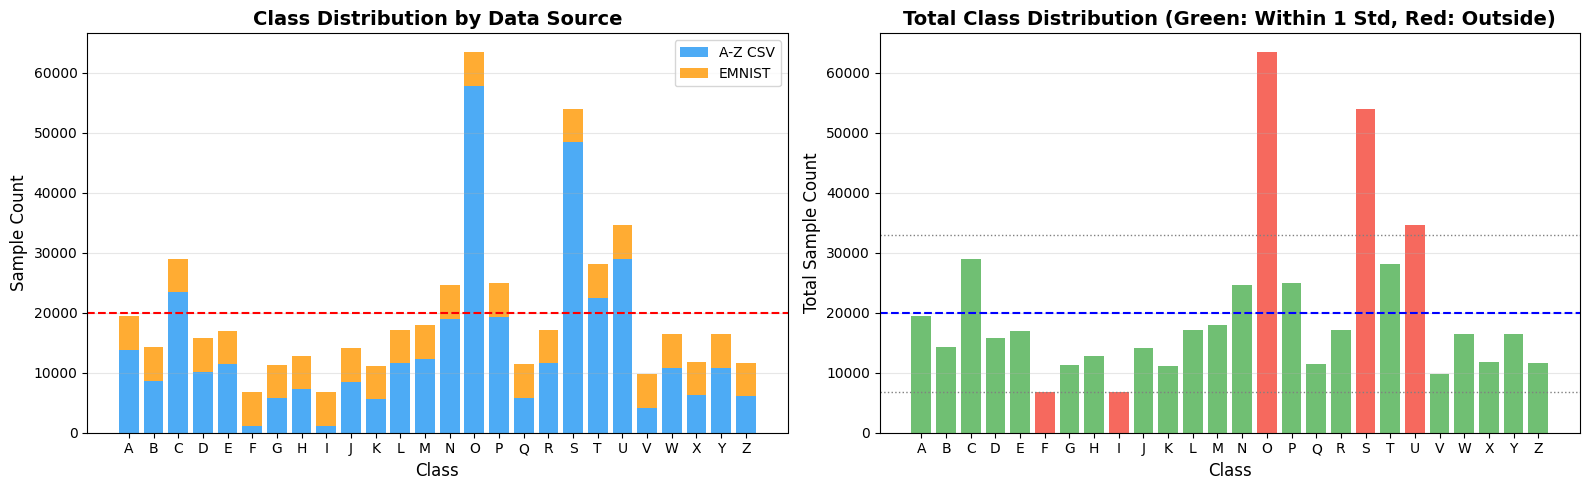

Class distribution visualization saved to 'phase3_class_distribution.png'


In [8]:
# =============================================================================
# Visualize Class Distribution
# =============================================================================
# Stacked bar chart showing contribution from each data source per class.
# This helps identify if certain classes are underrepresented in either source.
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Stacked bar chart by source
ax1 = axes[0]
x = np.arange(26)
width = 0.8

bars1 = ax1.bar(x, az_class_counts, width, label='A-Z CSV', color='#2196F3', alpha=0.8)
bars2 = ax1.bar(x, emnist_class_counts, width, bottom=az_class_counts,
                label='EMNIST', color='#FF9800', alpha=0.8)

ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Sample Count', fontsize=12)
ax1.set_title('Class Distribution by Data Source', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(class_names)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Add horizontal line for mean
ax1.axhline(y=mean_count, color='red', linestyle='--', linewidth=1.5,
            label=f'Mean: {mean_count:,.0f}')

# Plot 2: Total distribution with imbalance highlighting
ax2 = axes[1]
colors = ['#4CAF50' if abs(count - mean_count) < std_count else '#F44336'
          for count in total_class_counts]

bars3 = ax2.bar(x, total_class_counts, width, color=colors, alpha=0.8)
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Total Sample Count', fontsize=12)
ax2.set_title('Total Class Distribution (Green: Within 1 Std, Red: Outside)',
              fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(class_names)
ax2.axhline(y=mean_count, color='blue', linestyle='--', linewidth=1.5)
ax2.axhline(y=mean_count + std_count, color='gray', linestyle=':', linewidth=1)
ax2.axhline(y=mean_count - std_count, color='gray', linestyle=':', linewidth=1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('phase3_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Class distribution visualization saved to 'phase3_class_distribution.png'")

### 4.3 Visual Sample Verification: Orientation and Alignment Check

Display random samples from both datasets to visually confirm:
1. A-Z CSV images are correctly formatted
2. EMNIST orientation correction is working properly
3. Both sources produce visually similar, correctly oriented letters

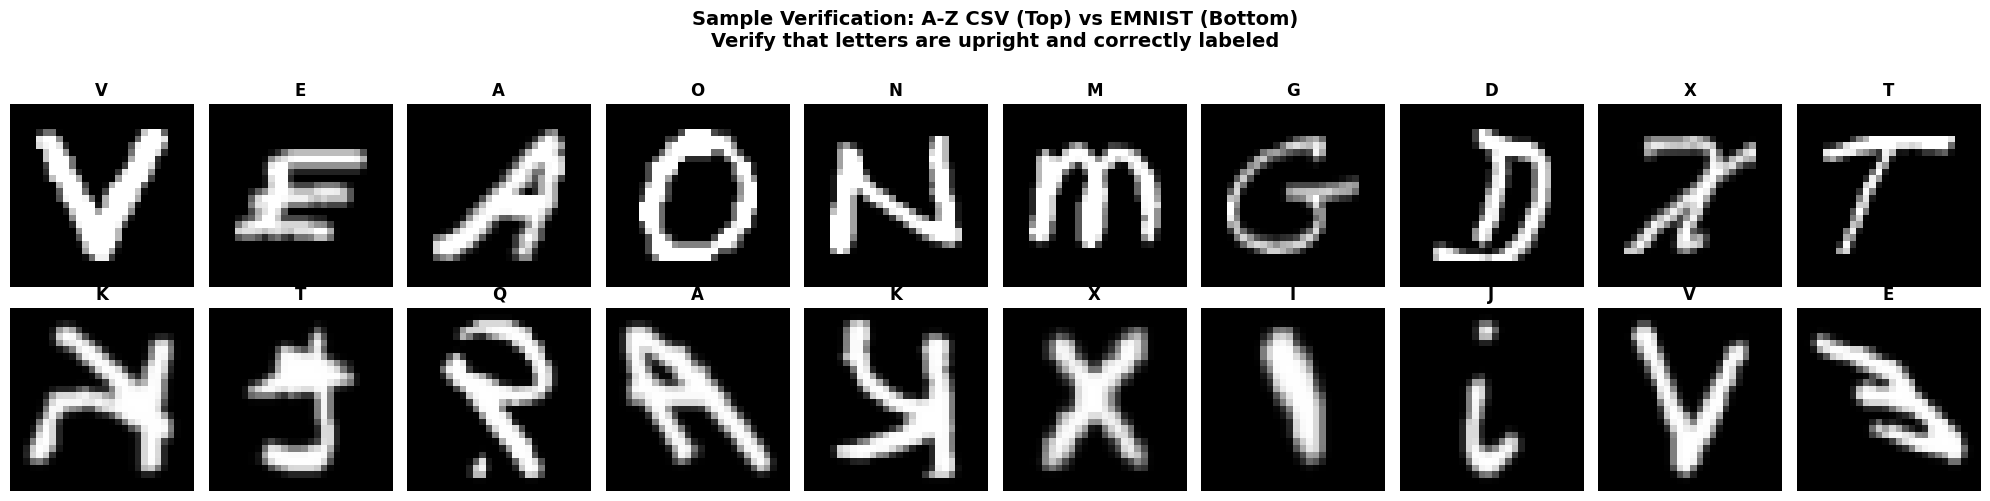

Sample verification saved to 'phase3_sample_verification.png'

VISUAL CHECK:
  - Letters should appear UPRIGHT (not rotated or mirrored)
  - Labels above images should match the displayed character
  - Both rows should show similar visual quality


In [9]:
# =============================================================================
# Visual Sample Verification
# =============================================================================
# Display 10 random samples from A-Z CSV and 10 from EMNIST side-by-side.
# This visual check confirms:
#   1. Images are correctly oriented (letters should be upright and readable)
#   2. Preprocessing produces consistent appearance across sources
#   3. Labels match the displayed characters
# =============================================================================

import random

def denormalize(tensor, mean, std):
    """Reverse normalization for visualization."""
    return tensor * std + mean

# Set random seed for reproducibility
random.seed(42)

# Sample 10 random indices from A-Z CSV
az_indices = random.sample(range(combined_dataset.total_az), 10)

# Sample 10 random indices from EMNIST
emnist_start = combined_dataset.total_az
emnist_indices = random.sample(range(emnist_start, len(combined_dataset)), 10)

# Create figure with 2 rows (A-Z CSV on top, EMNIST on bottom)
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

# Row 1: A-Z CSV samples
for i, idx in enumerate(az_indices):
    img, label = combined_dataset[idx]

    # Denormalize for visualization
    img_display = denormalize(img.squeeze(), PHASE2_NORM_MEAN, PHASE2_NORM_STD)
    img_display = img_display.numpy()

    axes[0, i].imshow(img_display, cmap='gray')
    axes[0, i].set_title(f'{chr(65 + label)}', fontsize=12, fontweight='bold')
    axes[0, i].axis('off')

axes[0, 0].set_ylabel('A-Z CSV', fontsize=12, fontweight='bold')

# Row 2: EMNIST samples
for i, idx in enumerate(emnist_indices):
    img, label = combined_dataset[idx]

    # Denormalize for visualization
    img_display = denormalize(img.squeeze(), PHASE2_NORM_MEAN, PHASE2_NORM_STD)
    img_display = img_display.numpy()

    axes[1, i].imshow(img_display, cmap='gray')
    axes[1, i].set_title(f'{chr(65 + label)}', fontsize=12, fontweight='bold')
    axes[1, i].axis('off')

axes[1, 0].set_ylabel('EMNIST', fontsize=12, fontweight='bold')

plt.suptitle('Sample Verification: A-Z CSV (Top) vs EMNIST (Bottom)\n'
             'Verify that letters are upright and correctly labeled',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('phase3_sample_verification.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample verification saved to 'phase3_sample_verification.png'")
print("\nVISUAL CHECK:")
print("  - Letters should appear UPRIGHT (not rotated or mirrored)")
print("  - Labels above images should match the displayed character")
print("  - Both rows should show similar visual quality")

## 5. Fine-Tuning Pipeline
### 5.1 Data Preparation: Train/Validation Split and DataLoaders

In [10]:
# =============================================================================
# Train/Validation Split and DataLoader Configuration
# =============================================================================
# For fine-tuning on real-world data, we:
#   1. Split the combined dataset into train (80%) and validation (20%)
#   2. Use large batch sizes (512-1024) for efficiency with large datasets
#   3. Enable pin_memory and multiple workers for fast data transfer to GPU
#
# Note: With >500K samples, a 20% validation set (~100K samples) provides
# statistically robust evaluation metrics.
# =============================================================================

from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import gc

# Fine-tuning configuration
FINETUNE_CONFIG = {
    'batch_size': 512,              # Large batch for efficient GPU utilization
    'validation_split': 0.2,        # 80/20 train/validation split
    'num_workers': 4,               # Parallel data loading workers
    'pin_memory': True,             # Faster GPU data transfer
    'shuffle_train': True,          # Shuffle training data each epoch
    'shuffle_val': False,           # No need to shuffle validation data
}

print(f"{'='*60}")
print("FINE-TUNING DATA CONFIGURATION")
print(f"{'='*60}")

# Calculate split sizes
total_samples = len(combined_dataset)
val_size = int(total_samples * FINETUNE_CONFIG['validation_split'])
train_size = total_samples - val_size

print(f"Total Samples: {total_samples:,}")
print(f"Training Samples: {train_size:,} ({100 - FINETUNE_CONFIG['validation_split']*100:.0f}%)")
print(f"Validation Samples: {val_size:,} ({FINETUNE_CONFIG['validation_split']*100:.0f}%)")

# Create train/validation split using random_split
# This preserves the dataset structure while creating non-overlapping subsets
train_dataset, val_dataset = random_split(
    combined_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # Reproducible split
)

print(f"\nSplit Complete:")
print(f"  Train subset length: {len(train_dataset):,}")
print(f"  Validation subset length: {len(val_dataset):,}")

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=FINETUNE_CONFIG['batch_size'],
    shuffle=FINETUNE_CONFIG['shuffle_train'],
    num_workers=FINETUNE_CONFIG['num_workers'],
    pin_memory=FINETUNE_CONFIG['pin_memory'],
    drop_last=True  # Drop incomplete last batch for consistent batch norm behavior
)

val_loader = DataLoader(
    val_dataset,
    batch_size=FINETUNE_CONFIG['batch_size'],
    shuffle=FINETUNE_CONFIG['shuffle_val'],
    num_workers=FINETUNE_CONFIG['num_workers'],
    pin_memory=FINETUNE_CONFIG['pin_memory'],
    drop_last=False  # Keep all validation samples
)

print(f"\nDataLoader Configuration:")
print(f"  Batch Size: {FINETUNE_CONFIG['batch_size']}")
print(f"  Training Batches per Epoch: {len(train_loader):,}")
print(f"  Validation Batches: {len(val_loader):,}")
print(f"  Num Workers: {FINETUNE_CONFIG['num_workers']}")
print(f"  Pin Memory: {FINETUNE_CONFIG['pin_memory']}")

# Verify batch dimensions
sample_batch, sample_labels = next(iter(train_loader))
print(f"\nBatch Verification:")
print(f"  Batch Images Shape: {sample_batch.shape}")
print(f"  Batch Labels Shape: {sample_labels.shape}")
print(f"  Expected: ({FINETUNE_CONFIG['batch_size']}, 1, 28, 28)")

# Clean up
del sample_batch, sample_labels
gc.collect()

print(f"{'='*60}")

FINE-TUNING DATA CONFIGURATION
Total Samples: 518,051
Training Samples: 414,441 (80%)
Validation Samples: 103,610 (20%)

Split Complete:
  Train subset length: 414,441
  Validation subset length: 103,610

DataLoader Configuration:
  Batch Size: 512
  Training Batches per Epoch: 809
  Validation Batches: 203
  Num Workers: 4
  Pin Memory: True


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Batch Verification:
  Batch Images Shape: torch.Size([512, 1, 28, 28])
  Batch Labels Shape: torch.Size([512])
  Expected: (512, 1, 28, 28)


### 5.2 Load Pretrained Model Weights

Load the state dictionary from the Phase 1/2 trained model (`icr_v2_best.pth`).
This provides a strong initialization for fine-tuning on real-world data.

In [11]:
# =============================================================================
# Load Pretrained Model for Fine-Tuning
# =============================================================================
# We load the weights from Phase 2 training (icr_v2_best.pth).
# This transfer learning approach leverages the features learned from
# synthetic data and adapts them to real-world handwriting variations.
#
# Strategy Decision: FULL MODEL FINE-TUNING
# -----------------------------------------
# We unfreeze ALL layers (no frozen layers) because:
#   1. The domain shift from synthetic to real data may require adaptation
#      at all network levels
#   2. Using a very low learning rate (1e-5) prevents catastrophic forgetting
#   3. The model is relatively small (~200K params), so full fine-tuning
#      is computationally feasible
#
# Alternative (not used): Freeze convolutional layers and only train FC layers.
# This would be faster but may limit adaptation capability.
# =============================================================================

import torch
import torch.nn as nn

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Model checkpoint path from Phase 2
PHASE2_CHECKPOINT = 'icr_v2_best.pth'

# Instantiate fresh model architecture
model = ICR_V2_Model(
    num_classes=26,
    dropout_rate=0.5
).to(device)

print(f"\n{'='*60}")
print("LOADING PRETRAINED WEIGHTS")
print(f"{'='*60}")

# Load state dictionary
if Path(PHASE2_CHECKPOINT).exists():
    checkpoint = torch.load(PHASE2_CHECKPOINT, map_location=device)

    # Handle different checkpoint formats
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
        print(f"Checkpoint contains training metadata")
        if 'epoch' in checkpoint:
            print(f"  Trained for: {checkpoint['epoch']} epochs")
        if 'best_val_acc' in checkpoint:
            print(f"  Best validation accuracy: {checkpoint['best_val_acc']:.4f}")
    else:
        state_dict = checkpoint
        print(f"Checkpoint contains state_dict only")

    # Load weights
    model.load_state_dict(state_dict)
    print(f"Weights loaded successfully from: {PHASE2_CHECKPOINT}")
else:
    print(f"WARNING: Checkpoint not found at {PHASE2_CHECKPOINT}")
    print("Model will be trained from scratch (random initialization)")

# Verify all layers are trainable (unfrozen)
print(f"\n{'='*60}")
print("LAYER FREEZE STATUS (All should be trainable)")
print(f"{'='*60}")

total_params = 0
trainable_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
        status = "TRAINABLE"
    else:
        status = "FROZEN"
    print(f"  {name:30s} | {status}")

print(f"\n{'='*60}")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Frozen Parameters: {total_params - trainable_params:,}")
print(f"{'='*60}")

Training Device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB

LOADING PRETRAINED WEIGHTS
Checkpoint contains training metadata
  Trained for: 20 epochs
  Best validation accuracy: 98.2747
Weights loaded successfully from: icr_v2_best.pth

LAYER FREEZE STATUS (All should be trainable)
  conv1.weight                   | TRAINABLE
  conv1.bias                     | TRAINABLE
  bn1.weight                     | TRAINABLE
  bn1.bias                       | TRAINABLE
  conv2.weight                   | TRAINABLE
  conv2.bias                     | TRAINABLE
  bn2.weight                     | TRAINABLE
  bn2.bias                       | TRAINABLE
  conv3.weight                   | TRAINABLE
  conv3.bias                     | TRAINABLE
  bn3.weight                     | TRAINABLE
  bn3.bias                       | TRAINABLE
  fc1.weight                     | TRAINABLE
  fc1.bias                       | TRAINABLE
  bn_fc.weight                   | TRAINABLE
  bn_fc.bias                     | TRAINABLE

### 5.3 Fine-Tuning Hyperparameters and Training Components

Configure optimizer, learning rate scheduler, and loss function for fine-tuning.
Key consideration: Use a LOW learning rate to preserve pretrained knowledge.

In [13]:
# =============================================================================
# Fine-Tuning Hyperparameters
# =============================================================================
# CRITICAL: Learning Rate Selection for Fine-Tuning
# -------------------------------------------------
# When fine-tuning a pretrained model, the learning rate must be significantly
# lower than initial training to avoid:
#   1. Catastrophic forgetting: Erasing useful features learned from synthetic data
#   2. Overshooting: Large weight updates destroying the initialization
#
# Typical fine-tuning LR: 1/10 to 1/100 of original training LR
#   - Phase 2 used LR = 1e-4
#   - Fine-tuning uses LR = 1e-5 (10x smaller)
#
# Optimizer: AdamW
# ----------------
# AdamW decouples weight decay from the gradient update, providing better
# regularization than standard Adam. This helps prevent overfitting on the
# larger real-world dataset.
# =============================================================================

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# Fine-tuning hyperparameters
FINETUNE_HYPERPARAMS = {
    'learning_rate': 1e-5,          # 10x lower than Phase 2
    'weight_decay': 1e-4,           # L2 regularization
    'num_epochs': 10,               # Fine-tuning epochs (fewer than initial training)
    'early_stop_patience': 3,       # Stop if no improvement for 3 epochs
    'scheduler_patience': 2,        # Reduce LR after 2 epochs without improvement
    'scheduler_factor': 0.5,        # Halve LR on plateau
    'min_lr': 1e-7,                 # Minimum learning rate
}

print(f"{'='*60}")
print("FINE-TUNING HYPERPARAMETERS")
print(f"{'='*60}")
for key, value in FINETUNE_HYPERPARAMS.items():
    print(f"  {key}: {value}")

# Loss Function: CrossEntropyLoss
# Handles multi-class classification with logits (no softmax needed)
criterion = nn.CrossEntropyLoss()

# Optimizer: AdamW with weight decay
optimizer = optim.AdamW(
    model.parameters(),
    lr=FINETUNE_HYPERPARAMS['learning_rate'],
    weight_decay=FINETUNE_HYPERPARAMS['weight_decay'],
    betas=(0.9, 0.999),  # Default Adam betas
    eps=1e-8
)

# Learning Rate Scheduler: ReduceLROnPlateau
# Reduces LR when validation loss plateaus
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',  # Minimize validation loss
    factor=FINETUNE_HYPERPARAMS['scheduler_factor'],
    patience=FINETUNE_HYPERPARAMS['scheduler_patience'],
    min_lr=FINETUNE_HYPERPARAMS['min_lr']
)

print(f"\nTraining Components Initialized:")
print(f"  Loss Function: CrossEntropyLoss")
print(f"  Optimizer: AdamW (lr={FINETUNE_HYPERPARAMS['learning_rate']}, weight_decay={FINETUNE_HYPERPARAMS['weight_decay']})")
print(f"  Scheduler: ReduceLROnPlateau (factor={FINETUNE_HYPERPARAMS['scheduler_factor']}, patience={FINETUNE_HYPERPARAMS['scheduler_patience']})")
print(f"{'='*60}")

FINE-TUNING HYPERPARAMETERS
  learning_rate: 1e-05
  weight_decay: 0.0001
  num_epochs: 10
  early_stop_patience: 3
  scheduler_patience: 2
  scheduler_factor: 0.5
  min_lr: 1e-07

Training Components Initialized:
  Loss Function: CrossEntropyLoss
  Optimizer: AdamW (lr=1e-05, weight_decay=0.0001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


### 5.4 Dimension Compatibility Verification

Before starting training, verify that the model input/output dimensions match the data dimensions exactly. This prevents runtime errors during the training loop.

In [14]:
# =============================================================================
# Dimension Compatibility Verification
# =============================================================================
# Before training, we perform a forward pass with a sample batch to verify:
#   1. Input shape compatibility (batch, 1, 28, 28)
#   2. Output shape correctness (batch, 26)
#   3. No dimension mismatch errors
#
# This is a critical safety check for production training pipelines.
# =============================================================================

print(f"{'='*60}")
print("DIMENSION COMPATIBILITY CHECK")
print(f"{'='*60}")

# Get a sample batch
model.eval()  # Set to eval mode for forward pass
with torch.no_grad():
    sample_batch, sample_labels = next(iter(train_loader))
    sample_batch = sample_batch.to(device)
    sample_labels = sample_labels.to(device)

    print(f"\n[INPUT VERIFICATION]")
    print(f"  Batch Shape: {sample_batch.shape}")
    print(f"  Expected:    (batch_size, 1, 28, 28)")
    print(f"  Match: {'PASS' if sample_batch.shape[1:] == (1, 28, 28) else 'FAIL'}")

    print(f"\n[LABELS VERIFICATION]")
    print(f"  Labels Shape: {sample_labels.shape}")
    print(f"  Labels Range: [{sample_labels.min().item()}, {sample_labels.max().item()}]")
    print(f"  Expected Range: [0, 25]")
    label_valid = sample_labels.min().item() >= 0 and sample_labels.max().item() <= 25
    print(f"  Match: {'PASS' if label_valid else 'FAIL'}")

    # Forward pass
    print(f"\n[FORWARD PASS VERIFICATION]")
    try:
        outputs = model(sample_batch)
        print(f"  Output Shape: {outputs.shape}")
        print(f"  Expected:     (batch_size, 26)")
        output_valid = outputs.shape[1] == 26
        print(f"  Match: {'PASS' if output_valid else 'FAIL'}")

        # Verify loss computation
        loss = criterion(outputs, sample_labels)
        print(f"\n[LOSS COMPUTATION VERIFICATION]")
        print(f"  Loss Value: {loss.item():.4f}")
        print(f"  Loss Valid: {'PASS' if not torch.isnan(loss) and not torch.isinf(loss) else 'FAIL'}")

    except Exception as e:
        print(f"  FORWARD PASS FAILED: {e}")
        raise RuntimeError("Dimension compatibility check failed. Cannot proceed with training.")

# Clean up
del sample_batch, sample_labels, outputs, loss
torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"\n{'='*60}")
print("ALL DIMENSION CHECKS PASSED - Ready for Training")
print(f"{'='*60}")

DIMENSION COMPATIBILITY CHECK

[INPUT VERIFICATION]
  Batch Shape: torch.Size([512, 1, 28, 28])
  Expected:    (batch_size, 1, 28, 28)
  Match: PASS

[LABELS VERIFICATION]
  Labels Shape: torch.Size([512])
  Labels Range: [0, 25]
  Expected Range: [0, 25]
  Match: PASS

[FORWARD PASS VERIFICATION]
  Output Shape: torch.Size([512, 26])
  Expected:     (batch_size, 26)
  Match: PASS

[LOSS COMPUTATION VERIFICATION]
  Loss Value: 4.7957
  Loss Valid: PASS

ALL DIMENSION CHECKS PASSED - Ready for Training


### 5.5 Fine-Tuning Training Loop

The main training loop with:
- Progress bars via tqdm
- Per-epoch metrics tracking
- Early stopping
- Best model checkpointing
- Learning rate scheduling

In [15]:
# =============================================================================
# Fine-Tuning Training Loop
# =============================================================================
# This training loop implements:
#   1. Epoch-level training with batch progress bars
#   2. Validation after each epoch
#   3. Learning rate scheduling based on validation loss
#   4. Early stopping to prevent overfitting
#   5. Best model checkpointing
#   6. Detailed metrics logging
#
# Memory Optimization:
#   - Gradients cleared after each backward pass
#   - CUDA cache cleared periodically
#   - No unnecessary tensor retention
# =============================================================================

import time
import copy
from tqdm.notebook import tqdm

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        model: PyTorch model
        train_loader: Training DataLoader
        criterion: Loss function
        optimizer: Optimizer
        device: Training device (cuda/cpu)

    Returns:
        tuple: (average_loss, accuracy)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc='Training', leave=False)

    for batch_idx, (images, labels) in enumerate(progress_bar):
        # Move data to device
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100. * correct / total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """
    Validate the model on the validation set.

    Args:
        model: PyTorch model
        val_loader: Validation DataLoader
        criterion: Loss function
        device: Device (cuda/cpu)

    Returns:
        tuple: (average_loss, accuracy)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(val_loader, desc='Validation', leave=False)

    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


def fine_tune_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs,
    early_stop_patience,
    checkpoint_path='icr_v2_finetuned.pth'
):
    """
    Main fine-tuning training loop with early stopping and checkpointing.

    Args:
        model: PyTorch model with pretrained weights
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: LR scheduler
        device: Training device
        num_epochs: Maximum number of epochs
        early_stop_patience: Epochs to wait before early stopping
        checkpoint_path: Path to save best model

    Returns:
        dict: Training history containing losses and accuracies
    """
    print(f"\n{'='*60}")
    print("STARTING FINE-TUNING")
    print(f"{'='*60}")
    print(f"Epochs: {num_epochs}")
    print(f"Early Stop Patience: {early_stop_patience}")
    print(f"Checkpoint Path: {checkpoint_path}")
    print(f"{'='*60}\n")

    # Initialize tracking variables
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch + 1}/{num_epochs} | LR: {current_lr:.2e}")
        print("-" * 50)

        # Training phase
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        epoch_time = time.time() - epoch_start

        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
        print(f"Time: {epoch_time:.1f}s")

        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0

            # Save checkpoint
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'best_val_loss': best_val_loss,
                'history': history,
            }, checkpoint_path)

            print(f"[CHECKPOINT] New best model saved (Val Acc: {best_val_acc*100:.2f}%)")
        else:
            epochs_no_improve += 1
            print(f"[NO IMPROVEMENT] {epochs_no_improve}/{early_stop_patience}")

        print()

        # Early stopping check
        if epochs_no_improve >= early_stop_patience:
            print(f"{'='*60}")
            print(f"EARLY STOPPING TRIGGERED at Epoch {epoch + 1}")
            print(f"{'='*60}")
            break

        # Clear CUDA cache periodically
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_time = time.time() - start_time

    # Load best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final summary
    print(f"\n{'='*60}")
    print("FINE-TUNING COMPLETE")
    print(f"{'='*60}")
    print(f"Total Time: {total_time/60:.1f} minutes")
    print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Final Model: {checkpoint_path}")
    print(f"{'='*60}")

    return history


print("Training functions defined successfully.")

Training functions defined successfully.


### 5.6 Execute Fine-Tuning

In [16]:
# =============================================================================
# Execute Fine-Tuning on Real-World Data
# =============================================================================
# Run the fine-tuning loop with all configured parameters.
# The best model will be saved to 'icr_v2.2_best.pth'.
# =============================================================================

FINETUNED_CHECKPOINT = 'icr_v2.2_best.pth'

# Execute fine-tuning
history = fine_tune_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=FINETUNE_HYPERPARAMS['num_epochs'],
    early_stop_patience=FINETUNE_HYPERPARAMS['early_stop_patience'],
    checkpoint_path=FINETUNED_CHECKPOINT
)


STARTING FINE-TUNING
Epochs: 10
Early Stop Patience: 3
Checkpoint Path: icr_v2.2_best.pth

Epoch 1/10 | LR: 1.00e-05
--------------------------------------------------


Training:   0%|          | 0/809 [00:00<?, ?it/s]

Validation:   0%|          | 0/203 [00:00<?, ?it/s]

Train Loss: 2.3484 | Train Acc: 48.73%
Val Loss:   0.9005 | Val Acc:   75.69%
Time: 49.8s
[CHECKPOINT] New best model saved (Val Acc: 75.69%)

Epoch 2/10 | LR: 1.00e-05
--------------------------------------------------


Training:   0%|          | 0/809 [00:00<?, ?it/s]

Validation:   0%|          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.9687 | Train Acc: 72.76%
Val Loss:   0.5165 | Val Acc:   84.84%
Time: 49.5s
[CHECKPOINT] New best model saved (Val Acc: 84.84%)

Epoch 3/10 | LR: 1.00e-05
--------------------------------------------------


Training:   0%|          | 0/809 [00:00<?, ?it/s]

Validation:   0%|          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.6427 | Train Acc: 80.70%
Val Loss:   0.3725 | Val Acc:   89.19%
Time: 48.6s
[CHECKPOINT] New best model saved (Val Acc: 89.19%)

Epoch 4/10 | LR: 1.00e-05
--------------------------------------------------


Training:   0%|          | 0/809 [00:00<?, ?it/s]

Validation:   0%|          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.4953 | Train Acc: 84.99%
Val Loss:   0.2997 | Val Acc:   91.32%
Time: 49.0s
[CHECKPOINT] New best model saved (Val Acc: 91.32%)

Epoch 5/10 | LR: 1.00e-05
--------------------------------------------------


Training:   0%|          | 0/809 [00:00<?, ?it/s]

Validation:   0%|          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.4097 | Train Acc: 87.58%
Val Loss:   0.2541 | Val Acc:   92.63%
Time: 49.3s
[CHECKPOINT] New best model saved (Val Acc: 92.63%)

Epoch 6/10 | LR: 1.00e-05
--------------------------------------------------


Training:   0%|          | 0/809 [00:00<?, ?it/s]

Validation:   0%|          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.3530 | Train Acc: 89.35%
Val Loss:   0.2231 | Val Acc:   93.49%
Time: 49.5s
[CHECKPOINT] New best model saved (Val Acc: 93.49%)

Epoch 7/10 | LR: 1.00e-05
--------------------------------------------------


Training:   0%|          | 0/809 [00:00<?, ?it/s]

Validation:   0%|          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.3111 | Train Acc: 90.57%
Val Loss:   0.2001 | Val Acc:   94.16%
Time: 48.9s
[CHECKPOINT] New best model saved (Val Acc: 94.16%)

Epoch 8/10 | LR: 1.00e-05
--------------------------------------------------


Training:   0%|          | 0/809 [00:00<?, ?it/s]

Validation:   0%|          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.2807 | Train Acc: 91.49%
Val Loss:   0.1829 | Val Acc:   94.61%
Time: 49.8s
[CHECKPOINT] New best model saved (Val Acc: 94.61%)

Epoch 9/10 | LR: 1.00e-05
--------------------------------------------------


Training:   0%|          | 0/809 [00:00<?, ?it/s]

Validation:   0%|          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.2573 | Train Acc: 92.21%
Val Loss:   0.1691 | Val Acc:   95.01%
Time: 49.6s
[CHECKPOINT] New best model saved (Val Acc: 95.01%)

Epoch 10/10 | LR: 1.00e-05
--------------------------------------------------


Training:   0%|          | 0/809 [00:00<?, ?it/s]

Validation:   0%|          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.2376 | Train Acc: 92.79%
Val Loss:   0.1582 | Val Acc:   95.32%
Time: 50.5s
[CHECKPOINT] New best model saved (Val Acc: 95.32%)


FINE-TUNING COMPLETE
Total Time: 8.2 minutes
Best Validation Accuracy: 95.32%
Best Validation Loss: 0.1582
Final Model: icr_v2.2_best.pth


### 5.7 Training Curves Visualization

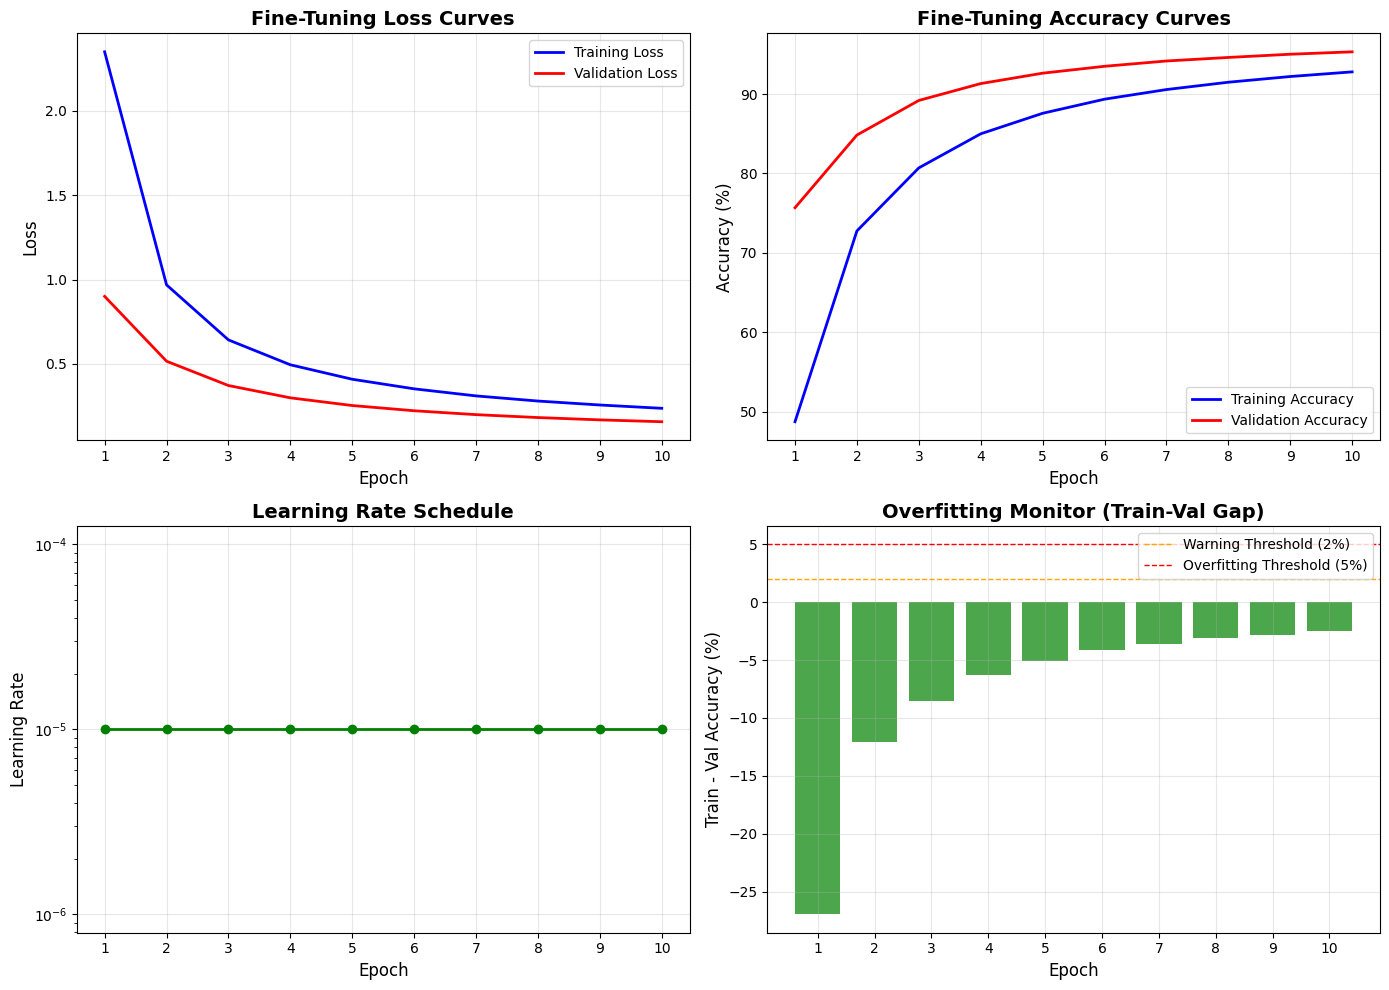

Training curves saved to 'icrv2.2_training_curves.png'


In [17]:
# =============================================================================
# Visualize Fine-Tuning Training Curves
# =============================================================================
# Plot the training history to analyze:
#   1. Loss convergence (train vs validation)
#   2. Accuracy progression
#   3. Learning rate schedule
#   4. Overfitting indicators (train-val gap)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs_range = range(1, len(history['train_loss']) + 1)

# Plot 1: Training and Validation Loss
ax1 = axes[0, 0]
ax1.plot(epochs_range, history['train_loss'], 'b-', linewidth=2, label='Training Loss')
ax1.plot(epochs_range, history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Fine-Tuning Loss Curves', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs_range)

# Plot 2: Training and Validation Accuracy
ax2 = axes[0, 1]
ax2.plot(epochs_range, [acc * 100 for acc in history['train_acc']], 'b-',
         linewidth=2, label='Training Accuracy')
ax2.plot(epochs_range, [acc * 100 for acc in history['val_acc']], 'r-',
         linewidth=2, label='Validation Accuracy')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Fine-Tuning Accuracy Curves', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epochs_range)

# Plot 3: Learning Rate Schedule
ax3 = axes[1, 0]
ax3.plot(epochs_range, history['lr'], 'g-', linewidth=2, marker='o')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Learning Rate', fontsize=12)
ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(epochs_range)

# Plot 4: Train-Validation Gap (Overfitting Indicator)
ax4 = axes[1, 1]
train_val_gap = [t - v for t, v in zip(history['train_acc'], history['val_acc'])]
colors = ['green' if gap < 0.02 else 'orange' if gap < 0.05 else 'red' for gap in train_val_gap]
ax4.bar(epochs_range, [gap * 100 for gap in train_val_gap], color=colors, alpha=0.7)
ax4.axhline(y=2, color='orange', linestyle='--', linewidth=1, label='Warning Threshold (2%)')
ax4.axhline(y=5, color='red', linestyle='--', linewidth=1, label='Overfitting Threshold (5%)')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Train - Val Accuracy (%)', fontsize=12)
ax4.set_title('Overfitting Monitor (Train-Val Gap)', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)
ax4.set_xticks(epochs_range)

plt.tight_layout()
plt.savefig('icrv2.2_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to 'icrv2.2_training_curves.png'")

## 6. Fine-Tuned Model Evaluation
### 6.1 Per-Class Performance Analysis

In [18]:
# =============================================================================
# Per-Class Performance Analysis on Validation Set
# =============================================================================
# Compute detailed metrics including:
#   - Per-class accuracy
#   - Confusion matrix
#   - Classification report (precision, recall, F1)
# =============================================================================

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_per_class(model, val_loader, device, class_names):
    """
    Evaluate model performance per class.

    Args:
        model: Trained PyTorch model
        val_loader: Validation DataLoader
        device: Device (cuda/cpu)
        class_names: List of class names (A-Z)

    Returns:
        tuple: (all_predictions, all_labels, per_class_accuracy)
    """
    model.eval()
    all_preds = []
    all_labels = []

    print("Collecting predictions on validation set...")
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Evaluating'):
            images = images.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Per-class accuracy
    per_class_acc = {}
    for i, name in enumerate(class_names):
        mask = all_labels == i
        if mask.sum() > 0:
            per_class_acc[name] = (all_preds[mask] == all_labels[mask]).mean()
        else:
            per_class_acc[name] = 0.0

    return all_preds, all_labels, per_class_acc

# Run evaluation
class_names = [chr(65 + i) for i in range(26)]
all_preds, all_labels, per_class_acc = evaluate_per_class(model, val_loader, device, class_names)

# Print per-class accuracy
print(f"\n{'='*60}")
print("PER-CLASS ACCURACY (Fine-Tuned Model)")
print(f"{'='*60}")
print(f"{'Class':<8} {'Accuracy':>12}")
print(f"{'─'*25}")
for name in class_names:
    print(f"{name:<8} {per_class_acc[name]*100:>11.2f}%")
print(f"{'─'*25}")
print(f"{'Overall':<8} {np.mean(list(per_class_acc.values()))*100:>11.2f}%")
print(f"{'='*60}")

# Identify worst performing classes
sorted_acc = sorted(per_class_acc.items(), key=lambda x: x[1])
print(f"\nWorst Performing Classes:")
for name, acc in sorted_acc[:5]:
    print(f"  {name}: {acc*100:.2f}%")

Evaluating:   0%|          | 0/203 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



PER-CLASS ACCURACY (Fine-Tuned Model)
Class        Accuracy
─────────────────────────
A              94.41%
B              95.35%
C              97.15%
D              89.08%
E              95.37%
F              94.81%
G              82.10%
H              93.62%
I              77.51%
J              88.21%
K              94.18%
L              88.94%
M              98.29%
N              96.23%
O              99.15%
P              97.44%
Q              85.78%
R              94.28%
S              98.38%
T              97.97%
U              97.50%
V              94.52%
W              97.51%
X              96.14%
Y              94.63%
Z              94.09%
─────────────────────────
Overall        93.56%

Worst Performing Classes:
  I: 77.51%
  G: 82.10%
  Q: 85.78%
  J: 88.21%
  L: 88.94%


### 6.2 Confusion Matrix Visualization

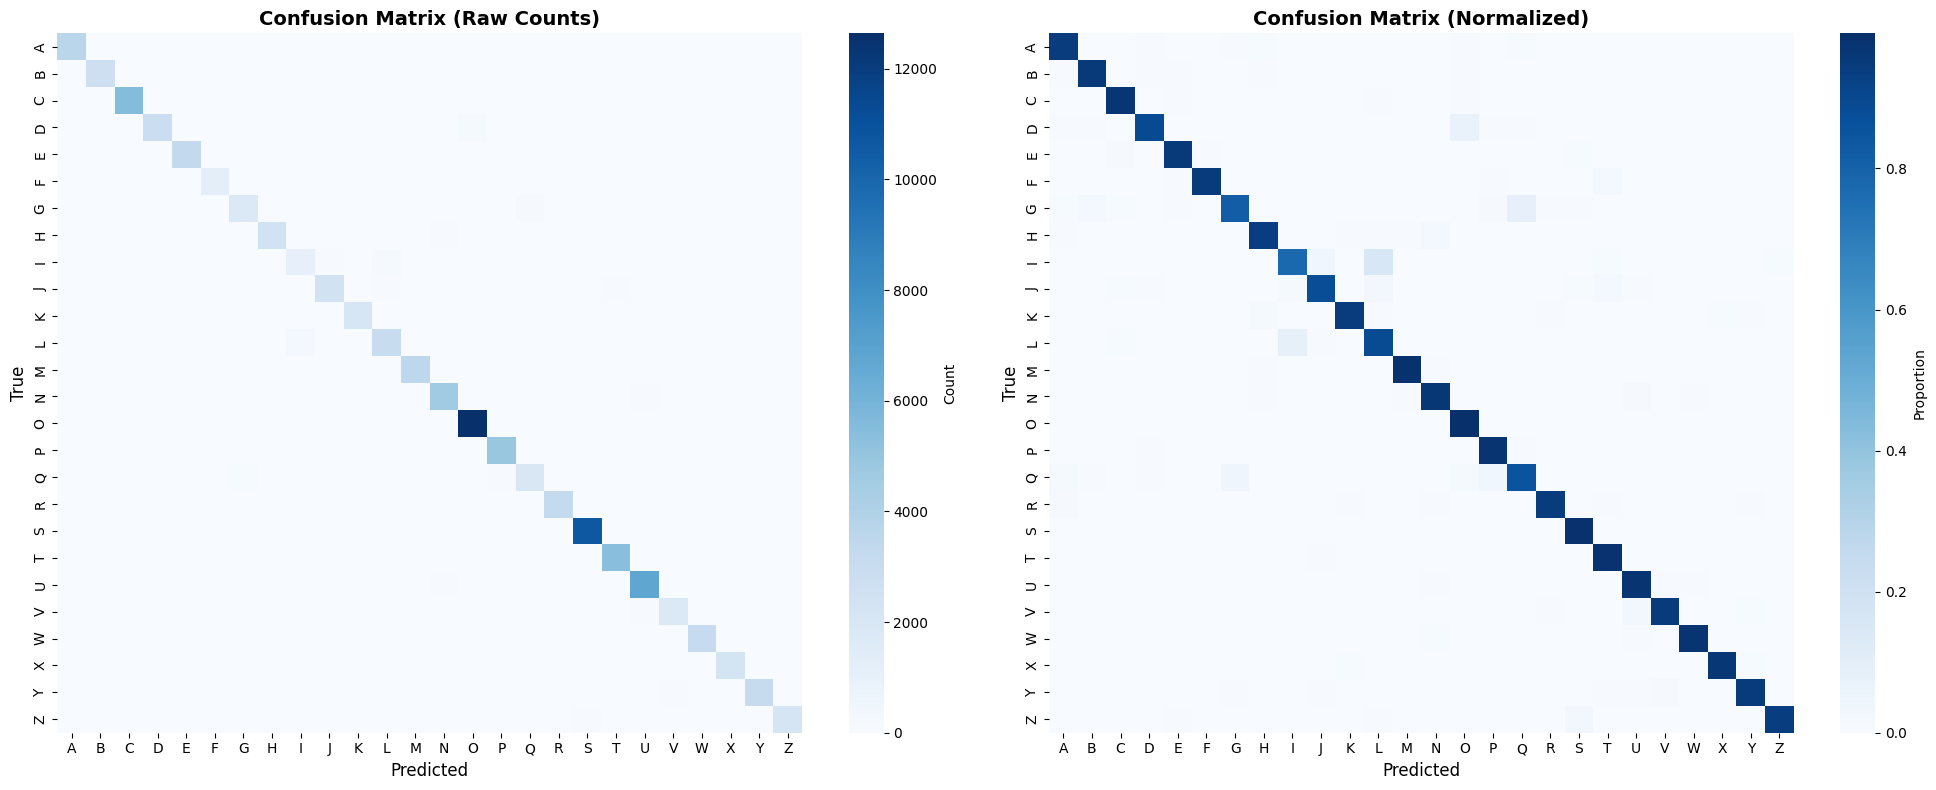

Confusion matrix saved to 'icrv2.2_confusion_matrix.png'

MOST CONFUSED CHARACTER PAIRS
True     Predicted       Count       Rate
────────────────────────────────────────
L        I                 292      8.54%
D        O                 232      7.28%
I        L                 217     15.79%
G        Q                 181      8.22%
Q        G                 100      4.38%
Q        P                  81      3.54%
Z        S                  77      3.32%
J        L                  75      2.71%
J        T                  62      2.24%
V        U                  60      3.13%


In [19]:
# =============================================================================
# Confusion Matrix Visualization
# =============================================================================
# The confusion matrix reveals which character pairs are commonly confused.
# This is particularly important for similar-looking letters like:
#   - O and Q
#   - I and L
#   - S and Z
#   - C and G
# =============================================================================

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize for better visualization (row-wise normalization)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
ax1 = axes[0]
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('True', fontsize=12)
ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')

# Normalized (percentages)
ax2 = axes[1]
sns.heatmap(cm_normalized, annot=False, fmt='.1%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax2,
            cbar_kws={'label': 'Proportion'})
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('True', fontsize=12)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('icrv2.2_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to 'icrv2.2_confusion_matrix.png'")

# Identify most confused pairs
print(f"\n{'='*60}")
print("MOST CONFUSED CHARACTER PAIRS")
print(f"{'='*60}")

# Find off-diagonal elements with highest values
confused_pairs = []
for i in range(26):
    for j in range(26):
        if i != j and cm[i, j] > 0:
            confused_pairs.append((class_names[i], class_names[j], cm[i, j], cm_normalized[i, j]))

# Sort by confusion count
confused_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"{'True':<8} {'Predicted':<10} {'Count':>10} {'Rate':>10}")
print(f"{'─'*40}")
for true_cls, pred_cls, count, rate in confused_pairs[:10]:
    print(f"{true_cls:<8} {pred_cls:<10} {count:>10,} {rate*100:>9.2f}%")

### 6.3 Classification Report

In [20]:
# =============================================================================
# Classification Report (Precision, Recall, F1-Score)
# =============================================================================
# Comprehensive metrics for each class:
#   - Precision: Of all predicted as class X, how many were correct?
#   - Recall: Of all actual class X samples, how many were correctly identified?
#   - F1-Score: Harmonic mean of precision and recall
# =============================================================================

print(f"{'='*60}")
print("CLASSIFICATION REPORT (ICR V2.2 Fine-Tuned Model)")
print(f"{'='*60}\n")

report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)

# Save report to file
with open('icrv2.2_classification_report.txt', 'w') as f:
    f.write("ICR V2.2 - Fine-Tuning Classification Report\n")
    f.write("=" * 60 + "\n\n")
    f.write(report)

print("\nClassification report saved to 'icrv2.2_classification_report.txt'")

CLASSIFICATION REPORT (ICR V2.2 Fine-Tuned Model)

              precision    recall  f1-score   support

           A     0.9448    0.9441    0.9445      3864
           B     0.9465    0.9535    0.9500      2858
           C     0.9705    0.9715    0.9710      5727
           D     0.9476    0.8908    0.9184      3188
           E     0.9626    0.9537    0.9582      3459
           F     0.9402    0.9481    0.9441      1309
           G     0.8897    0.8210    0.8540      2201
           H     0.9333    0.9362    0.9347      2632
           I     0.7386    0.7751    0.7564      1374
           J     0.9235    0.8821    0.9023      2765
           K     0.9563    0.9418    0.9490      2232
           L     0.8801    0.8894    0.8847      3418
           M     0.9791    0.9829    0.9810      3616
           N     0.9541    0.9623    0.9582      4822
           O     0.9714    0.9915    0.9814     12750
           P     0.9620    0.9744    0.9682      5043
           Q     0.8623    0.8

## 7. Summary and Model Export

Summary of the fine-tuning and final model export for deployment.

In [21]:
# =============================================================================
# ICR V2.2 Summary and Model Export
# =============================================================================
# Generate a comprehensive summary of the fine-tuning and export
# the final model in multiple formats for deployment flexibility.
# =============================================================================

import json
from datetime import datetime

# Calculate final metrics
final_train_acc = history['train_acc'][-1] * 100
final_val_acc = history['val_acc'][-1] * 100
best_val_acc = max(history['val_acc']) * 100
best_epoch = history['val_acc'].index(max(history['val_acc'])) + 1

print(f"{'='*60}")
print("ICR V2.2: FINE-TUNING SUMMARY")
print(f"{'='*60}")
print(f"\n[DATA SOURCES]")
print(f"  A-Z Handwritten CSV: {combined_dataset.total_az:,} samples")
print(f"  EMNIST Letters: {combined_dataset.total_emnist:,} samples")
print(f"  Total Training Data: {len(combined_dataset):,} samples")

print(f"\n[FINE-TUNING CONFIGURATION]")
print(f"  Base Model: icr_v2_best.pth (from ICR V2)")
print(f"  Strategy: Full model fine-tuning (all layers trainable)")
print(f"  Learning Rate: {FINETUNE_HYPERPARAMS['learning_rate']}")
print(f"  Optimizer: AdamW")
print(f"  Batch Size: {FINETUNE_CONFIG['batch_size']}")
print(f"  Epochs Trained: {len(history['train_loss'])}")

print(f"\n[PERFORMANCE METRICS]")
print(f"  Final Training Accuracy: {final_train_acc:.2f}%")
print(f"  Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")

print(f"\n[OUTPUT FILES]")
print(f"  Fine-tuned Model: {FINETUNED_CHECKPOINT}")
print(f"  Training Curves: icrv2.2_training_curves.png")
print(f"  Confusion Matrix: icrv2.2_confusion_matrix.png")
print(f"  Classification Report: icrv2.2_classification_report.txt")

# Export model metadata
metadata = {
    'model_name': 'ICR_V2.2_FineTuned',
    'version': '2.2.0',
    'date': datetime.now().isoformat(),
    'architecture': 'CNN (3 Conv Blocks + 2 FC Layers)',
    'input_shape': [1, 28, 28],
    'output_classes': 26,
    'normalization': {
        'mean': PHASE2_NORM_MEAN,
        'std': PHASE2_NORM_STD
    },
    'training': {
        'base_model': 'icr_v2_best.pth',
        'real_world_samples': len(combined_dataset),
        'az_csv_samples': combined_dataset.total_az,
        'emnist_samples': combined_dataset.total_emnist,
        'best_validation_accuracy': best_val_acc,
        'epochs_trained': len(history['train_loss'])
    }
}

# Save metadata
with open('icr_v2.2_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"  Metadata: icr_v2.2_metadata.json")

# Export for inference (state_dict only, smaller file)
torch.save(model.state_dict(), 'icr_v2.2_weights.pth')
print(f"  Inference Weights: icr_v2.2_weights.pth")

print(f"\n{'='*60}")
print("ICR V2.2 COMPLETE")
print(f"{'='*60}")

ICR V2.2: FINE-TUNING SUMMARY

[DATA SOURCES]
  A-Z Handwritten CSV: 372,451 samples
  EMNIST Letters: 145,600 samples
  Total Training Data: 518,051 samples

[FINE-TUNING CONFIGURATION]
  Base Model: icr_v2_best.pth (from ICR V2)
  Strategy: Full model fine-tuning (all layers trainable)
  Learning Rate: 1e-05
  Optimizer: AdamW
  Batch Size: 512
  Epochs Trained: 10

[PERFORMANCE METRICS]
  Final Training Accuracy: 92.79%
  Final Validation Accuracy: 95.32%
  Best Validation Accuracy: 95.32% (Epoch 10)

[OUTPUT FILES]
  Fine-tuned Model: icr_v2.2_best.pth
  Training Curves: icrv2.2_training_curves.png
  Confusion Matrix: icrv2.2_confusion_matrix.png
  Classification Report: icrv2.2_classification_report.txt
  Metadata: icr_v2.2_metadata.json
  Inference Weights: icr_v2.2_weights.pth

ICR V2.2 COMPLETE


## 8. Model Testing & Inference Demo

Test the fine-tuned model with:
1. Random samples from the validation dataset
2. External image file (custom handwritten letter)

TEST 1: VALIDATION SET SAMPLES



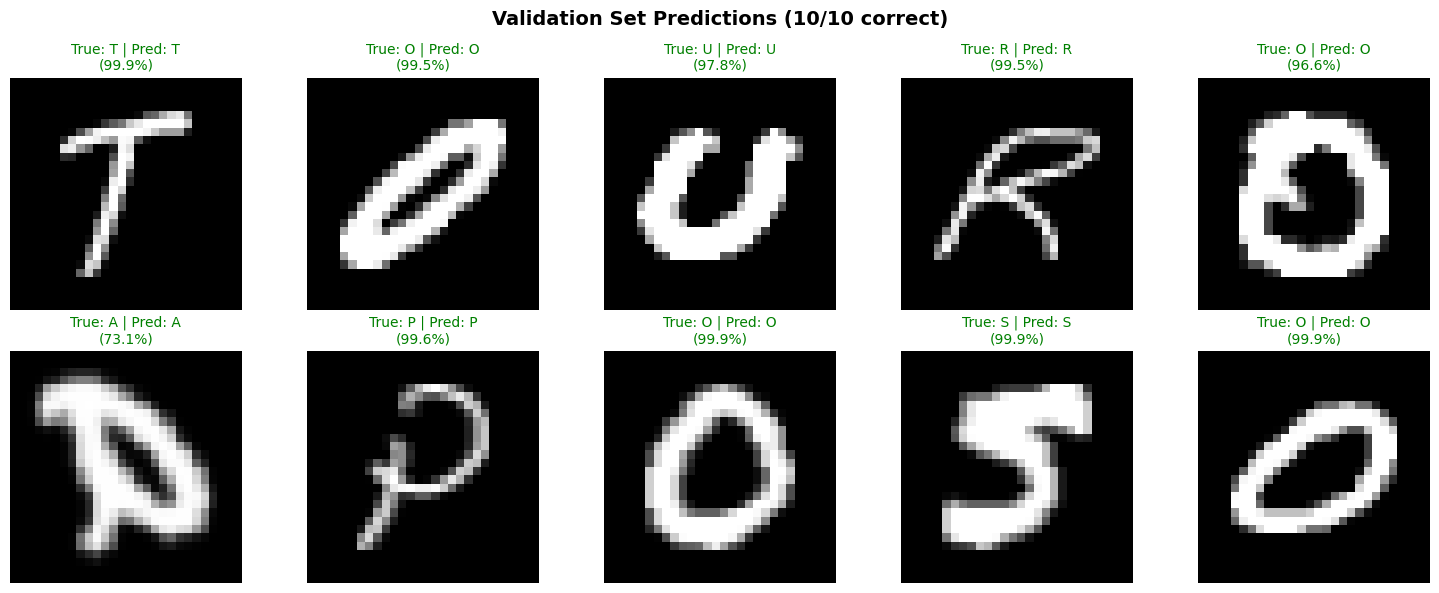

Accuracy on displayed samples: 10/10 (100%)

TEST 2: EXTERNAL IMAGE INFERENCE

HOW TO TEST YOUR HANDWRITTEN IMAGES

Use the following function:


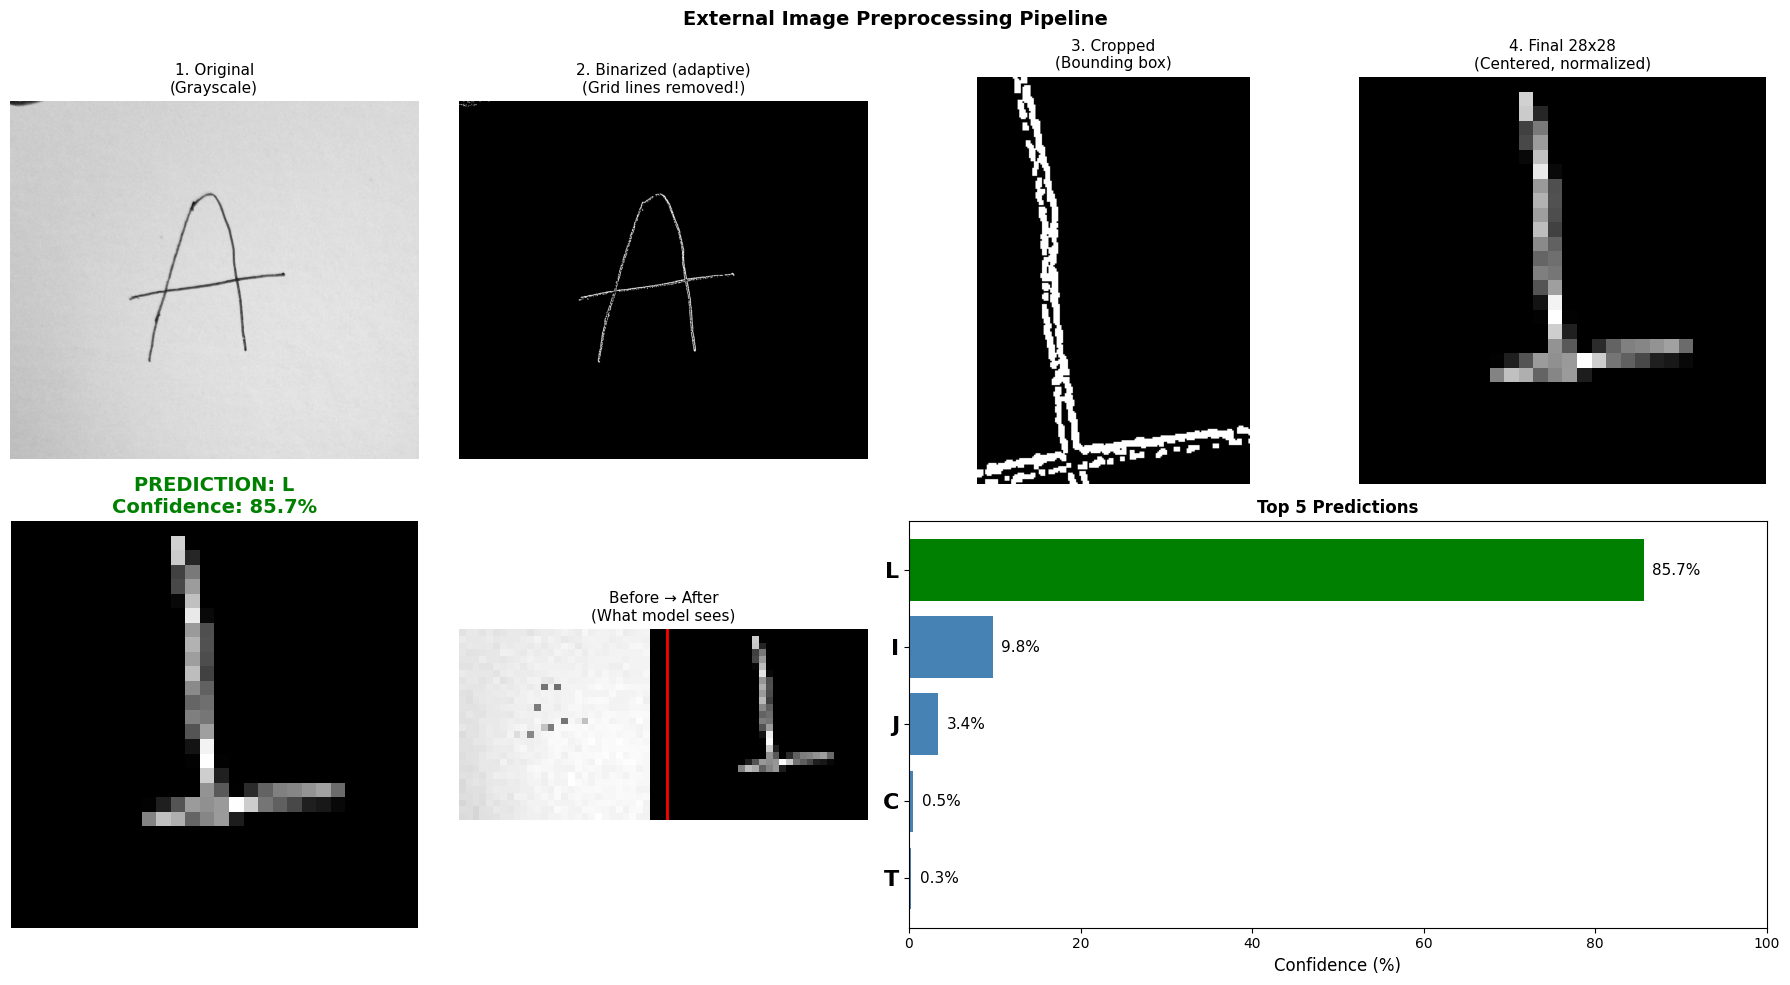


RESULT: L (Confidence: 85.7%)

Options:
  method='adaptive'  → Best for grid/lined paper (DEFAULT)
  method='otsu'      → Best for clean white paper

Example:


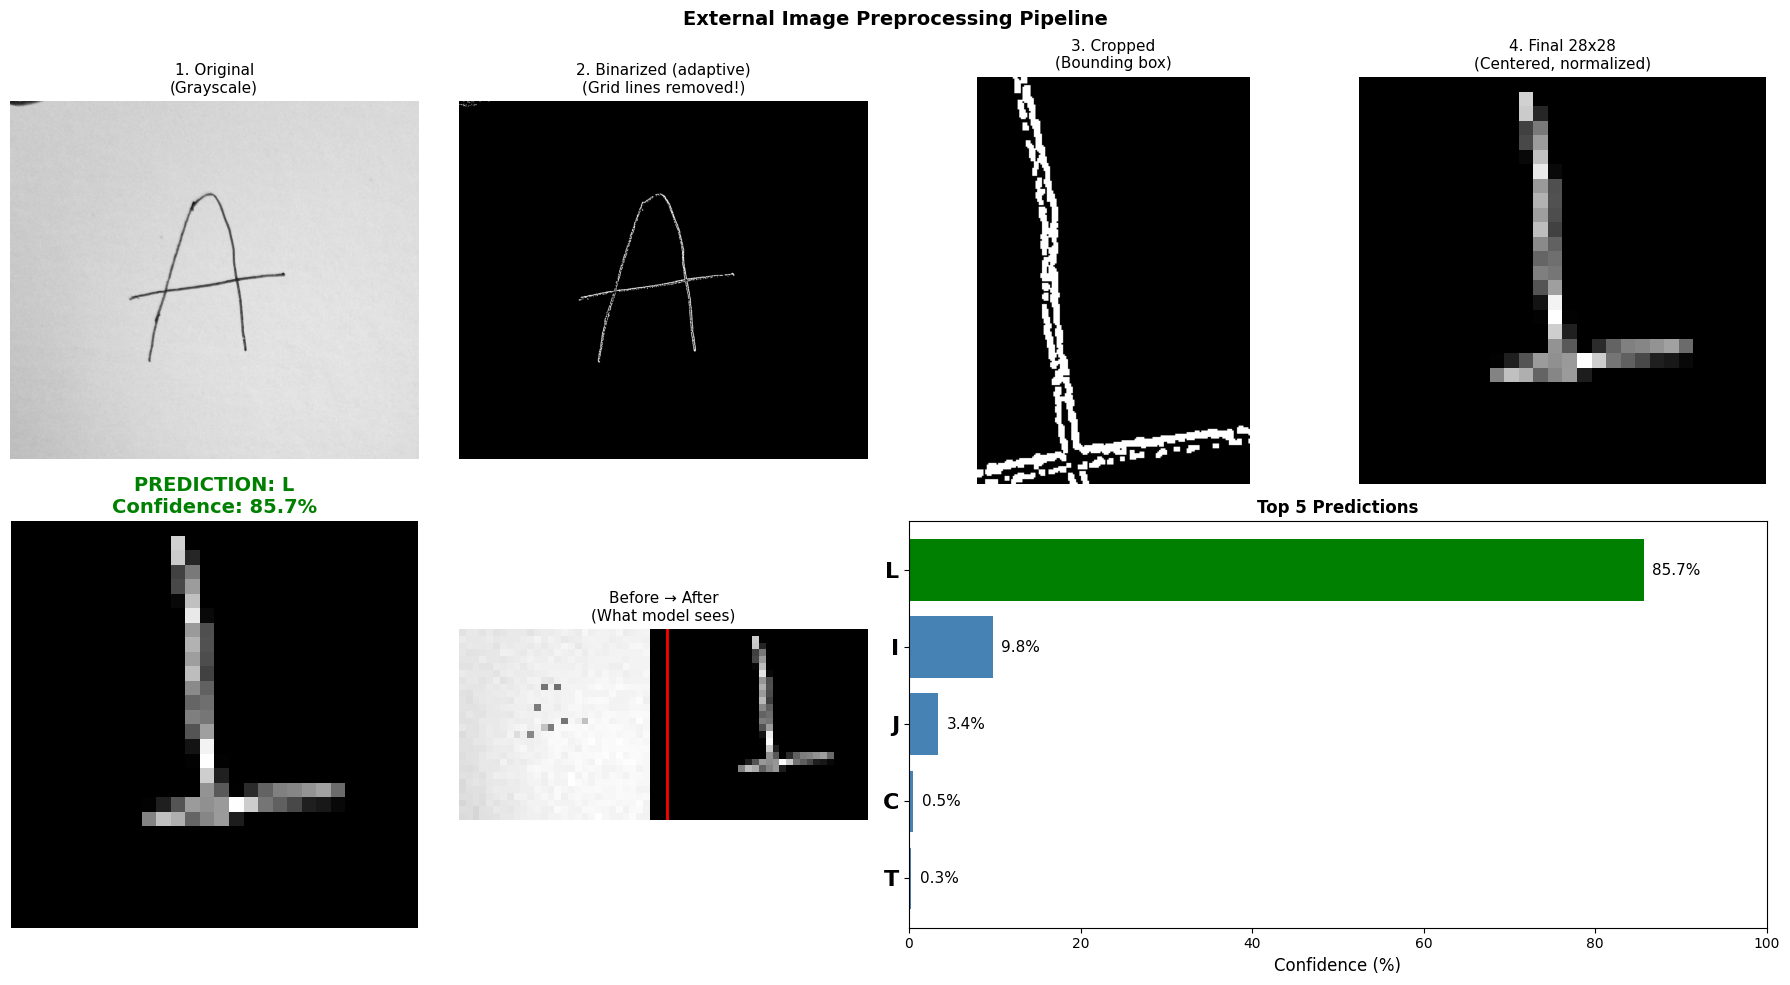


RESULT: L (Confidence: 85.7%)

PREPROCESSING PIPELINE:
1. Load as grayscale
2. BINARIZATION (removes grid lines!) using adaptive threshold
3. Morphological cleanup (removes noise)
4. Find largest contour (the letter)
5. Crop to bounding box
6. Make square and resize to 20x20
7. Center by center of mass in 28x28 canvas
8. Normalize with model's mean/std

Result: WHITE letter on BLACK background (like training data)


In [36]:
# =============================================================================
# Model Testing & Inference Demo
# =============================================================================
# This section demonstrates model inference on:
#   1. Random samples from the validation dataset
#   2. External images (custom handwritten letters)
#
# IMPORTANT: External images (especially on lined/grid paper) require
# proper binarization to remove background noise and isolate the letter.
# =============================================================================

from PIL import Image, ImageOps, ImageFilter
import random
import cv2
from scipy import ndimage

def predict_single_image(model, image_tensor, device, return_probs=False):
    """
    Predict a single image.

    Args:
        model: Trained model
        image_tensor: Preprocessed image tensor (1, 1, 28, 28)
        device: Device (cuda/cpu)
        return_probs: If True, return class probabilities

    Returns:
        tuple: (predicted_letter, confidence, [probabilities if return_probs])
    """
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = probs.max(1)

        predicted_letter = chr(65 + predicted.item())  # Convert 0-25 to A-Z
        confidence_pct = confidence.item() * 100

        if return_probs:
            return predicted_letter, confidence_pct, probs.cpu().numpy()[0]
        return predicted_letter, confidence_pct


def preprocess_external_image(image_path, mean=PHASE2_NORM_MEAN, std=PHASE2_NORM_STD,
                               debug=False, method='adaptive'):
    """
    Preprocess an external image for model inference.

    CRITICAL STEPS:
    1. Binarization (Otsu or Adaptive Threshold) - Removes grid lines and noise
    2. Color Inversion - Model expects WHITE letter on BLACK background
    3. Centering by center of mass - Like MNIST preprocessing

    Args:
        image_path: Path to the image file
        mean: Normalization mean
        std: Normalization std
        debug: If True, return preprocessing steps for visualization
        method: 'otsu' or 'adaptive' (adaptive is better for grid paper)

    Returns:
        torch.Tensor: Preprocessed image tensor (1, 28, 28)
    """
    # ==========================================================================
    # STEP 1: Load image in grayscale
    # ==========================================================================
    img_original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_original is None:
        raise ValueError(f"Could not load image: {image_path}")

    # ==========================================================================
    # STEP 2: BINARIZATION - THE MOST IMPORTANT STEP
    # This removes grid lines, noise, and creates pure black/white image
    # ==========================================================================

    if method == 'adaptive':
        # Adaptive Threshold - BEST for grid paper / uneven lighting
        # It calculates threshold for small regions, so grid lines disappear
        # Parameters:
        #   - blockSize: Size of neighborhood (must be odd). Larger = less sensitive to grid
        #   - C: Constant subtracted from mean. Higher = more aggressive binarization
        binary = cv2.adaptiveThreshold(
            img_original,
            maxValue=255,
            adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            thresholdType=cv2.THRESH_BINARY_INV,  # Invert: letter becomes WHITE
            blockSize=15,  # Neighborhood size (try 11, 15, 21 for different results)
            C=10           # Threshold offset (try 5-15)
        )
    else:
        # Otsu's Threshold - Good for uniform lighting, clean backgrounds
        # Automatically finds optimal threshold value
        _, binary = cv2.threshold(
            img_original,
            0,  # Threshold value (ignored when using OTSU)
            255,
            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU  # Invert + Otsu
        )

    # ==========================================================================
    # STEP 3: Morphological operations to clean up noise
    # ==========================================================================
    # Remove small noise (opening = erosion followed by dilation)
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Optional: Dilate slightly to make letter thicker
    kernel_dilate = np.ones((2, 2), np.uint8)
    binary = cv2.dilate(binary, kernel_dilate, iterations=1)

    # ==========================================================================
    # STEP 4: Find bounding box and crop to letter
    # ==========================================================================
    # Find contours to get the letter's bounding box
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("Warning: No contours found in image")
        return torch.zeros(1, 28, 28)

    # Find the largest contour (should be the letter)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Add padding around the letter
    pad = 5
    x = max(0, x - pad)
    y = max(0, y - pad)
    w = min(binary.shape[1] - x, w + 2 * pad)
    h = min(binary.shape[0] - y, h + 2 * pad)

    # Crop to bounding box
    cropped = binary[y:y+h, x:x+w]

    # ==========================================================================
    # STEP 5: Make square and resize to 20x20 (MNIST standard)
    # ==========================================================================
    # Make square by padding the shorter dimension
    max_dim = max(h, w)
    square = np.zeros((max_dim, max_dim), dtype=np.uint8)

    # Center the cropped image in the square
    y_offset = (max_dim - h) // 2
    x_offset = (max_dim - w) // 2
    square[y_offset:y_offset+h, x_offset:x_offset+w] = cropped

    # Resize to 20x20 (MNIST uses 20x20 content area)
    resized = cv2.resize(square, (20, 20), interpolation=cv2.INTER_AREA)

    # ==========================================================================
    # STEP 6: Center by center of mass in 28x28 canvas
    # ==========================================================================
    # Calculate center of mass
    if resized.sum() > 0:
        cy, cx = ndimage.center_of_mass(resized)
        cy, cx = int(round(cy)), int(round(cx))
    else:
        cy, cx = 10, 10

    # Create 28x28 canvas (black background)
    canvas = np.zeros((28, 28), dtype=np.uint8)

    # Calculate offset to place center of mass at canvas center (14, 14)
    # The 20x20 image will be placed with offset so its center of mass aligns with (14, 14)
    target_cy, target_cx = 14, 14
    offset_y = target_cy - cy
    offset_x = target_cx - cx

    # Clamp to valid range (0 to 8 since 28-20=8)
    offset_y = max(0, min(8, offset_y))
    offset_x = max(0, min(8, offset_x))

    # Place 20x20 in 28x28 canvas
    canvas[offset_y:offset_y+20, offset_x:offset_x+20] = resized

    # ==========================================================================
    # STEP 7: Normalize for model input
    # ==========================================================================
    # Convert to float [0, 1]
    normalized = canvas.astype(np.float32) / 255.0

    # Apply model normalization (mean and std from training)
    normalized = (normalized - mean) / std

    # Convert to tensor
    img_tensor = torch.from_numpy(normalized).unsqueeze(0).float()

    if debug:
        return img_tensor, {
            'original': img_original,
            'binary': binary,
            'cropped': cropped,
            'square': square,
            'resized_20': resized,
            'final_28': canvas
        }

    return img_tensor


# =============================================================================
# TEST 1: Random Samples from Validation Set
# =============================================================================
print(f"{'='*60}")
print("TEST 1: VALIDATION SET SAMPLES")
print(f"{'='*60}\n")

# Get random samples from validation set
num_samples = 10
val_indices = random.sample(range(len(val_dataset)), num_samples)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

correct = 0
for idx, (ax, val_idx) in enumerate(zip(axes, val_indices)):
    image, label = val_dataset[val_idx]
    true_letter = chr(65 + label)

    # Predict
    pred_letter, confidence = predict_single_image(model, image, device)
    is_correct = pred_letter == true_letter
    correct += int(is_correct)

    # Display image (denormalize for visualization)
    img_display = image.squeeze().numpy() * PHASE2_NORM_STD + PHASE2_NORM_MEAN
    img_display = np.clip(img_display, 0, 1)

    ax.imshow(img_display, cmap='gray')
    color = 'green' if is_correct else 'red'
    ax.set_title(f"True: {true_letter} | Pred: {pred_letter}\n({confidence:.1f}%)",
                 color=color, fontsize=10)
    ax.axis('off')

plt.suptitle(f"Validation Set Predictions ({correct}/{num_samples} correct)",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('icrv2.2_test_validation_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Accuracy on displayed samples: {correct}/{num_samples} ({100*correct/num_samples:.0f}%)")


# =============================================================================
# TEST 2: External Image Inference with Preprocessing Visualization
# =============================================================================
print(f"\n{'='*60}")
print("TEST 2: EXTERNAL IMAGE INFERENCE")
print(f"{'='*60}\n")

def test_external_image(image_path, method='adaptive', show_steps=True):
    """
    Test model on an external image with full preprocessing visualization.

    Args:
        image_path: Path to the image file
        method: 'adaptive' (better for grid paper) or 'otsu' (cleaner images)
        show_steps: If True, show all preprocessing steps
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    # Preprocess with debug info
    img_tensor, debug_info = preprocess_external_image(
        image_path, debug=True, method=method
    )

    # Predict
    pred_letter, confidence, probs = predict_single_image(
        model, img_tensor, device, return_probs=True
    )

    if show_steps:
        # Create visualization of all preprocessing steps
        fig = plt.figure(figsize=(18, 10))

        # Row 1: Preprocessing pipeline
        ax1 = fig.add_subplot(2, 4, 1)
        ax1.imshow(debug_info['original'], cmap='gray')
        ax1.set_title('1. Original\n(Grayscale)', fontsize=11)
        ax1.axis('off')

        ax2 = fig.add_subplot(2, 4, 2)
        ax2.imshow(debug_info['binary'], cmap='gray')
        ax2.set_title(f'2. Binarized ({method})\n(Grid lines removed!)', fontsize=11)
        ax2.axis('off')

        ax3 = fig.add_subplot(2, 4, 3)
        ax3.imshow(debug_info['cropped'], cmap='gray')
        ax3.set_title('3. Cropped\n(Bounding box)', fontsize=11)
        ax3.axis('off')

        ax4 = fig.add_subplot(2, 4, 4)
        ax4.imshow(debug_info['final_28'], cmap='gray')
        ax4.set_title('4. Final 28x28\n(Centered, normalized)', fontsize=11)
        ax4.axis('off')

        # Row 2: Results
        ax5 = fig.add_subplot(2, 4, 5)
        ax5.imshow(debug_info['final_28'], cmap='gray')
        color = 'green' if confidence > 80 else 'orange' if confidence > 50 else 'red'
        ax5.set_title(f'PREDICTION: {pred_letter}\nConfidence: {confidence:.1f}%',
                      fontsize=14, fontweight='bold', color=color)
        ax5.axis('off')

        # Compare: what model sees vs what you gave
        ax6 = fig.add_subplot(2, 4, 6)
        # Show side by side comparison
        comparison = np.zeros((28, 60), dtype=np.uint8)
        # Original resized to 28x28 for comparison
        orig_resized = cv2.resize(debug_info['original'], (28, 28))
        comparison[:, :28] = orig_resized
        comparison[:, 32:] = debug_info['final_28']
        ax6.imshow(comparison, cmap='gray')
        ax6.set_title('Before → After\n(What model sees)', fontsize=11)
        ax6.axvline(x=30, color='red', linewidth=2)
        ax6.axis('off')

        # Top 5 predictions
        ax7 = fig.add_subplot(2, 4, (7, 8))
        top5_idx = np.argsort(probs)[-5:][::-1]
        top5_letters = [chr(65 + i) for i in top5_idx]
        top5_probs = probs[top5_idx] * 100

        colors = ['green' if i == 0 else 'steelblue' for i in range(5)]
        bars = ax7.barh(range(5), top5_probs, color=colors)
        ax7.set_yticks(range(5))
        ax7.set_yticklabels(top5_letters, fontsize=16, fontweight='bold')
        ax7.set_xlabel('Confidence (%)', fontsize=12)
        ax7.set_title('Top 5 Predictions', fontsize=12, fontweight='bold')
        ax7.set_xlim(0, 100)
        ax7.invert_yaxis()

        for bar, prob in zip(bars, top5_probs):
            ax7.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                     f'{prob:.1f}%', va='center', fontsize=11)

        plt.suptitle('External Image Preprocessing Pipeline', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('icrv2.2_test_external_image.png', dpi=150, bbox_inches='tight')
        plt.show()

    print(f"\n{'='*40}")
    print(f"RESULT: {pred_letter} (Confidence: {confidence:.1f}%)")
    print(f"{'='*40}")

    return pred_letter, confidence


# Instructions for user
print("=" * 60)
print("HOW TO TEST YOUR HANDWRITTEN IMAGES")
print("=" * 60)
print("\nUse the following function:")
test_external_image('A1.jpg')
print("\nOptions:")
print("  method='adaptive'  → Best for grid/lined paper (DEFAULT)")
print("  method='otsu'      → Best for clean white paper")
print("\nExample:")
test_external_image('A1.jpg', method='adaptive')
print("\n" + "=" * 60)
print("PREPROCESSING PIPELINE:")
print("=" * 60)
print("1. Load as grayscale")
print("2. BINARIZATION (removes grid lines!) using adaptive threshold")
print("3. Morphological cleanup (removes noise)")
print("4. Find largest contour (the letter)")
print("5. Crop to bounding box")
print("6. Make square and resize to 20x20")
print("7. Center by center of mass in 28x28 canvas")
print("8. Normalize with model's mean/std")
print("\nResult: WHITE letter on BLACK background (like training data)")
print("=" * 60)


Processing: A.jpg


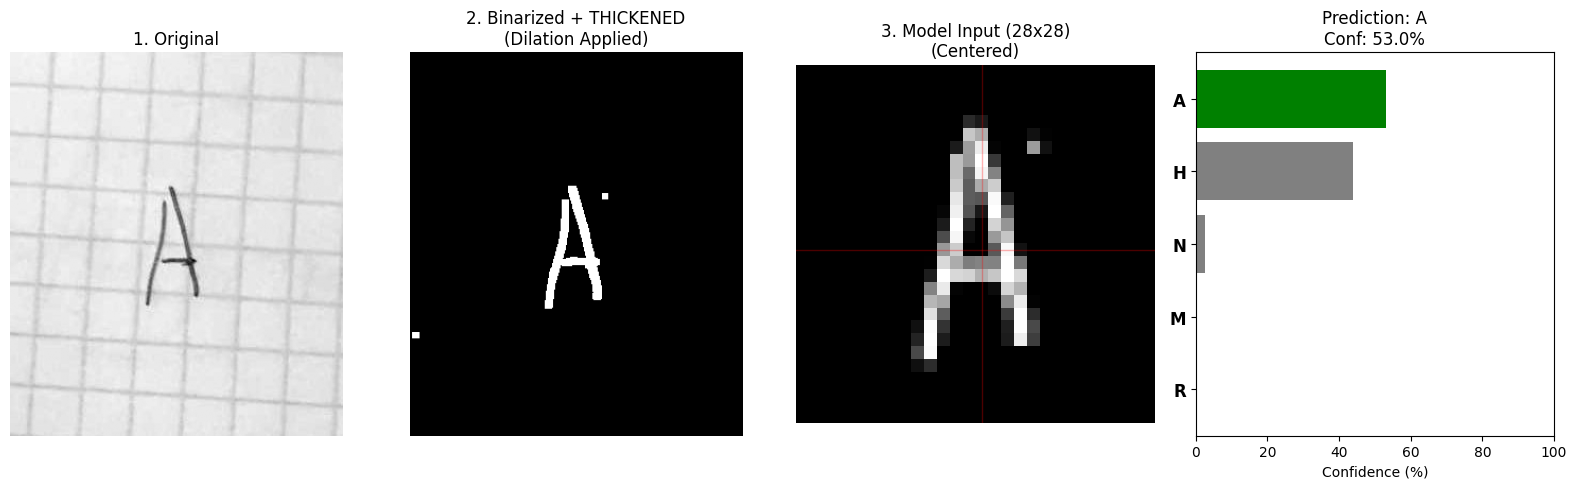

RESULT: A (53.0%)
Fonctions prêtes. Lancez 'test_external_image("votre_image.jpg")' pour tester.


In [67]:
# =============================================================================
# Model Testing & Inference Demo (Optimized for Thin Pen/Paper)
# =============================================================================
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
import os

# --- Configuration (Defaults to EMNIST/MNIST stats if variables missing) ---
# Si vos variables globales PHASE2... n'existent pas, ces valeurs par défaut seront utilisées
try:
    NORM_MEAN = PHASE2_NORM_MEAN
    NORM_STD = PHASE2_NORM_STD
except NameError:
    NORM_MEAN = 0.1307
    NORM_STD = 0.3081

def predict_single_image(model, image_tensor, device, return_probs=False):
    """
    Runs inference on a single image tensor.
    """
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0) # Add batch dim

        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = probs.max(1)

        predicted_letter = chr(65 + predicted.item()) # 0-25 -> A-Z
        confidence_pct = confidence.item() * 100

        if return_probs:
            return predicted_letter, confidence_pct, probs.cpu().numpy()[0]
        return predicted_letter, confidence_pct

def preprocess_external_image(image_path, mean=NORM_MEAN, std=NORM_STD,
                               debug=False, method='adaptive'):
    """
    Preprocess real-world images. Includes DILATION to fix thin strokes.
    """
    # 1. Load Image
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    img_original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_original is None:
        raise ValueError("Failed to load image.")

    # 2. Binarization
    if method == 'adaptive':
        # Best for grid paper or uneven lighting
        binary = cv2.adaptiveThreshold(
            img_original, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, 15, 10
        )
    else:
        # Best for clean white paper
        _, binary = cv2.threshold(
            img_original, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

    # 3. Denoise & THICKEN (Crucial for pen strokes)
    # Remove small noise
    kernel_clean = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_clean)

    # --- DILATION: Make thin lines fat ---
    # Kernel 3x3 with 2 iterations makes the letter solid for the model
    kernel_dilate = np.ones((3, 3), np.uint8)
    binary = cv2.dilate(binary, kernel_dilate, iterations=2)

    # 4. Find Contours & Crop
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("Warning: No contours found.")
        return torch.zeros(1, 28, 28)

    # Assume largest contour is the letter
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Pad crop slightly
    pad = 5
    x = max(0, x - pad)
    y = max(0, y - pad)
    w = min(binary.shape[1] - x, w + 2 * pad)
    h = min(binary.shape[0] - y, h + 2 * pad)
    cropped = binary[y:y+h, x:x+w]

    # 5. Make Square & Resize to 20x20
    max_dim = max(h, w)
    square = np.zeros((max_dim, max_dim), dtype=np.uint8)

    # Center in square
    y_off = (max_dim - h) // 2
    x_off = (max_dim - w) // 2
    square[y_off:y_off+h, x_off:x_off+w] = cropped

    # Resize to 20x20 using INTER_AREA (better for shrinking)
    resized = cv2.resize(square, (20, 20), interpolation=cv2.INTER_AREA)

    # 6. Center by Mass on 28x28 Canvas
    if resized.sum() > 0:
        cy, cx = ndimage.center_of_mass(resized)
        cy, cx = int(round(cy)), int(round(cx))
    else:
        cy, cx = 10, 10

    canvas = np.zeros((28, 28), dtype=np.uint8)

    # Target center: (14, 14)
    target_cx, target_cy = 14, 14
    dx = target_cx - cx
    dy = target_cy - cy

    # Calculate paste coordinates with boundary checking
    # Where to paste in canvas
    start_y = max(0, dy)
    start_x = max(0, dx)
    end_y = min(28, dy + 20)
    end_x = min(28, dx + 20)

    # Where to cut from resized image
    src_y = max(0, -dy)
    src_x = max(0, -dx)
    src_h = end_y - start_y
    src_w = end_x - start_x

    if src_h > 0 and src_w > 0:
        canvas[start_y:end_y, start_x:end_x] = resized[src_y:src_y+src_h, src_x:src_x+src_w]

    # 7. Normalize
    normalized = canvas.astype(np.float32) / 255.0
    normalized = (normalized - mean) / std
    img_tensor = torch.from_numpy(normalized).unsqueeze(0).float()

    if debug:
        return img_tensor, {
            'original': img_original,
            'binary': binary, # Now dilated
            'cropped': cropped,
            'final_28': canvas
        }
    return img_tensor

def test_external_image(image_path, method='adaptive'):
    """
    Visualizes the pipeline and prediction without saving files.
    """
    print(f"\nProcessing: {image_path}")

    if not os.path.exists(image_path):
        print("Error: Image not found.")
        return

    try:
        # Preprocess
        img_tensor, debug_info = preprocess_external_image(image_path, debug=True, method=method)

        # Predict
        pred, conf, probs = predict_single_image(model, img_tensor, device, return_probs=True)

        # Visualization
        fig, axes = plt.subplots(1, 4, figsize=(16, 5))

        # 1. Original
        axes[0].imshow(debug_info['original'], cmap='gray')
        axes[0].set_title("1. Original")
        axes[0].axis('off')

        # 2. Binary + Dilated
        axes[1].imshow(debug_info['binary'], cmap='gray')
        axes[1].set_title("2. Binarized + THICKENED\n(Dilation Applied)")
        axes[1].axis('off')

        # 3. Final Input
        axes[2].imshow(debug_info['final_28'], cmap='gray')
        axes[2].set_title("3. Model Input (28x28)\n(Centered)")
        axes[2].axhline(y=14, color='r', alpha=0.3, linewidth=1)
        axes[2].axvline(x=14, color='r', alpha=0.3, linewidth=1)
        axes[2].axis('off')

        # 4. Probabilities
        top5_idx = np.argsort(probs)[-5:]
        top5_vals = probs[top5_idx] * 100
        top5_labels = [chr(65 + i) for i in top5_idx]

        colors = ['green' if l == pred else 'gray' for l in top5_labels]
        axes[3].barh(range(5), top5_vals, color=colors)
        axes[3].set_yticks(range(5))
        axes[3].set_yticklabels(top5_labels, fontsize=12, fontweight='bold')
        axes[3].set_xlabel('Confidence (%)')
        axes[3].set_title(f"Prediction: {pred}\nConf: {conf:.1f}%")
        axes[3].set_xlim(0, 100)

        plt.tight_layout()
        plt.show() # Only show, don't save

        print(f"RESULT: {pred} ({conf:.1f}%)")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

# =============================================================================
# RUN TEST
# =============================================================================
# Remplacez 'A1.jpg' par le nom de votre image uploadée
test_external_image('A.jpg', method='adaptive')
print("Fonctions prêtes. Lancez 'test_external_image(\"votre_image.jpg\")' pour tester.")